In [181]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 1000)
import numpy as np

from textblob import TextBlob
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import pyLDAvis
import pyLDAvis.sklearn

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='white', font_scale=2.5)

stopwords_base = stopwords.words('english')

In [2]:
df = pd.read_pickle('prepro/df_clean.pkl')

In [3]:
df.head()

body  \
0  fresh from my second experience with lsd and still beaming with the afterglow  i find myself back in the  real world  of work and taxes and congested transit lines once more  the australian bush  serene and simple  is an ideal place to trip on this beautiful substance  and i wish i could have stayed forever  but there will be another time  already eagerly awaited  to share this experience again with wonderful friends who understand exactly the joy and wonder of opening your mind to the beauty of natural creation    what can i call this trip but my final inauguration into the world of psychedelics  i ve had a rocky start on this journey  bad trips and major let downs that have filled my mind with doubt and anxiety  now i feel lsd has taught me the fundamental rules of psychonautics  the same lessons more experienced psychonauts have tried to instil in me  only this time  the sheer power of those hours under the night sky broke through my stubborn expectations and showed me  as they say  life changing    first  a little background  i started out with dextromethorphan  but discontinued after a third plateau trip that left me feeling like a broken soul who didn t really exist  i then moved on to mushrooms  starting with a two gram trip of a potent species  and it all went well enough until i encountered something so horrific  it shattered my resolve to use hallucinogens as tools for self discovery  and had me traumatised for a week  in the wake of the four worst hours of my life  i spent the next two months piecing together just what had gone so  so wrong  did i have some neurological disorder that prevents me from having an experience that isn t an acute psychotic episode  if i continued dabbling with these substances  would i lose my mind for good  if not for my desperate need for answers  i would have walked away at that point  and i often felt a wiser person would have done just that    bear with me as i describe this nightmare of a bad trip  imagine yourself walking about  ruminating on ever more confused and less sane philosophy about being god  when suddenly  all your senses warp into a confused mess  everything you see  hear and feel no longer makes the slightest sense  as your room transforms into a mesh of colours and you lose the ability to distinguish sound and touch from emotion and thought  it is to find yourself catapulted out of this human existence into some other place where nothing is solid  there is no time  sanity dissolves  and amid the absolute disorientation there is only one clear thought  oh  fuck    i have just fucked up my life    it s impossible to say how long this lasted  perhaps a minute  perhaps an hour  the only awareness i had of the outside world was that it must still be there  and that my friends and family must be so horrified that i destroyed my mind on drugs  as it began to clear  and the connections between percept and concept re established  i looked around the room with only slightly less confusion  what was this place  who was i  what was i  i had no idea  i spent the rest of the trip gradually working through the confusion to find myself again  i awoke next morning to severe depression and a conviction that i would never  ever touch drugs again    the night had been so confusing that it was only when i took acid two months later that i remembered this disconnect between my perceptions and my ability to interpret  the dissolution of boundary between thought and senses  all i had was vague memories of a hellish experience that felt like serious brain damage  but acid has a unique way of enhancing my imagination  and now that i understand just what happened  i ve come to know it as  the blur     i tried san pedro  only to find the specimen was inactive  i tried weed for the first time at four hits  and it triggered a minor flashback of the blur  which i no better understood  but it left me feeling that continuing hallucinogen use would be a sure one way ticket to that psychotic

## tf-idf NMF using entire corpus

In [4]:
# Function for building stopwords list

def build_stopwords(stopwords_base, stopwords_extension):
    stopwords_base.extend(stopwords_extension)
    
    return stopwords_base

In [5]:
# Function for getting top words in each topic

def print_top_words(model, feature_names, n_top_words=20):
    """
    Print top words in each topic
    """
    for ix, topic in enumerate(model.components_):
        inds = topic.argsort()
        print(f'Topic {ix}: \n')
        print(', '.join([feature_names[i] for i in inds[:-n_top_words - 1:-1]]))
        print('\n')

In [6]:
X_full = df['body']

In [7]:
# Add to base stopwords

drug_names = ['amphetamines', 'benzodiazepines', 'belladonna', 'cannabis', 'belladonna', 'cocaine', 'datura', 'dmt',
              'ketamine', 'lsd', 'mdma', 'mushrooms', 'nitrous', 'oxide', 'opioids', 'pcp', 'peyote', 'salvia',
              'divinorum', 'adderall', 'marijuana', 'psilocybin', 'morphine', 'vicodin', 'dilaudid', 'fentanyl',
              'opana', 'oxycontin', 'hydrocodone', 'methadone', 'oxycodone', 'heroin', 'ecstasy', 'opiate', 'opiates',
              'codeine', 'percocet', 'ecstasy', 'ecstacy']

drug_slang = ['pills', 'pill', 'benzos', 'weed', 'pot', 'herb', 'bowl', 'pipe', 'smoke', 'smoked', 'smoking', 'coke',
              'powder', 'mg', 'dose', 'trip', 'tripping', 'drug', 'drugs', 'shrooms', 'shroom', 'mushroom', 'snort',
              'snorted', 'acid', 'gram', 'grams', 'line', 'lines', 'crack', 'tab', 'tabs', 'blotter', 'roll',
              'rolling', 'rolled', 'bong', 'hit', 'hits', 'oxy', 'doses', 'snorting', 'iv', 'tablet',
              'tablets']

other = ['like', 'really', 'didn', 'couldn', 'wouldn', 'wasn', 'was', 'did', 'just', 'took', 'went', 'did', 've', 
         'got', 'started', 'felt', 'feeling', 'could', 'something', 'thing', 'things', 'would', 'experience' ,'time',
         'one', 'though', 'experiences', 'didnt', 'couldnt', 'wouldnt', 'dont', 'wasnt', 'im', 'alot', 'thats',
         'ive', 'kinda', 'cant', 'id', 'cuz', 'usually', 'slightly', 'seems', 'rather', 'although']

stopwords_extension = drug_names + drug_slang + other

In [8]:
stopwords = build_stopwords(stopwords_base, stopwords_extension)

In [9]:
tf_full = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1), max_df=.25, min_df=10)
X_tf_full = tf_full.fit_transform(X_full)

In [10]:
pd.DataFrame(X_tf_full.toarray(), columns=tf_full.get_feature_names()).head()

aaron   ab     aback  abandon  abandoned  abandoning  abandonment  abbey  \
0  0.0    0.0  0.000000  0.0      0.0        0.0         0.0          0.0     
1  0.0    0.0  0.000000  0.0      0.0        0.0         0.0          0.0     
2  0.0    0.0  0.000000  0.0      0.0        0.0         0.0          0.0     
3  0.0    0.0  0.050934  0.0      0.0        0.0         0.0          0.0     
4  0.0    0.0  0.000000  0.0      0.0        0.0         0.0          0.0     

   abdomen  aber  abilities   ability  abit  abject  abnormal  abnormally  \
0  0.0      0.0   0.00000    0.038841  0.0   0.0     0.0       0.0          
1  0.0      0.0   0.00000    0.000000  0.0   0.0     0.0       0.0          
2  0.0      0.0   0.00000    0.000000  0.0   0.0     0.0       0.0          
3  0.0      0.0   0.00000    0.000000  0.0   0.0     0.0       0.0          
4  0.0      0.0   0.05671    0.000000  0.0   0.0     0.0       0.0          

   aboard  abode  abort  aborted  abrasive  abroad  abrupt  abruptly  absence  \
0  0.0     0.0    0.0    0.0      0.0       0.0     0.0     0.0       0.0       
1  0.0     0.0    0.0    0.0      0.0       0.0     0.0     0.0       0.0       
2  0.0     0.0    0.0    0.0      0.0       0.0     0.0     0.0       0.0       
3  0.0     0.0    0.0    0.0      0.0       0.0     0.0     0.0       0.0       
4  0.0     0.0    0.0    0.0      0.0       0.0     0.0     0.0       0.0       

   absent  absinthe  absolute  absolutely  absolutley  absolutly   absorb  \
0  0.0     0.0       0.022062  0.0         0.0         0.0        0.02935   
1  0.0     0.0       0.000000  0.0         0.0         0.0        0.00000   
2  0.0     0.0       0.000000  0.0         0.0         0.0        0.00000   
3  0.0     0.0       0.000000  0.0         0.0         0.0        0.00000   
4  0.0     0.0       0.000000  0.0         0.0         0.0        0.00000   

   absorbed  absorbing  absorption  abstain  abstained  abstaining  \
0  0.000000  0.0        0.0         0.0      0.0        0.0          
1  0.000000  0.0        0.0         0.0      0.0        0.0          
2  0.034786  0.0        0.0         0.0      0.0        0.0          
3  0.000000  0.0        0.0         0.0      0.0        0.0          
4  0.000000  0.0        0.0         0.0      0.0        0.0          

   abstinence  abstract  abstraction  abstractions  absurd  absurdity  \
0  0.0         0.000000  0.0          0.0           0.0     0.0         
1  0.0         0.000000  0.0          0.0           0.0     0.0         
2  0.0         0.033515  0.0          0.0           0.0     0.0         
3  0.0         0.000000  0.0          0.0           0.0     0.0         
4  0.0         0.000000  0.0          0.0           0.0     0.0         

   absurdly  abundance  abundant  abuse  abused  abusing  abusive  abyss   ac  \
0  0.0       0.0        0.03768   0.0    0.0     0.0      0.0      0.0    0.0   
1  0.0       0.0        0.00000   0.0    0.0     0.0      0.0      0.0    0.0   
2  0.0       0.0        0.00000   0.0    0.0     0.0      0.0      0.0    0.0   
3  0.0       0.0        0.00000   0.0    0.0     0.0      0.0      0.0    0.0   
4  0.0       0.0        0.00000   0.0    0.0     0.0      0.0      0.0    0.0   

     acacia  academic  academically  accelerate  accelerated  accelerating  \
0  0.039512  0.0       0.0           0.0         0.0          0.0            
1  0.000000  0.0       0.0           0.0         0.0          0.0            
2  0.000000  0.0       0.0           0.0         0.0          0.0            
3  0.000000  0.0       0.0           0.0         0.0          0.0            
4  0.000000  0.0       0.0           0.0         0.0          0.0            

   acceleration  accent  accents  accentuated  accept  acceptable  acceptance  \
0  0.0           0.0     0.0      0.0          0.0     0.0         0.0          
1  0.0           0.0     0.0      0.0          0.0     0.0         0.0          
2  0.0           0.0     0.0      0.0          0.0     0

In [19]:
nmf_full = NMF(n_components=21, random_state=1)
doc_topic_full = nmf_full.fit_transform(X_tf_full)

In [20]:
print_top_words(nmf_full, tf_full.get_feature_names())

Topic 0: 

bathroom, movie, tv, couch, floor, door, watching, brother, shower, mirror, upstairs, kitchen, watch, watched, wall, ate, parents, living, asleep, downstairs


Topic 1: 

consciousness, self, universe, existence, human, ego, physical, energy, space, aware, within, words, death, fear, may, true, awareness, perhaps, understand, simply


Topic 2: 

euphoria, effect, feels, alcohol, less, definitely, relaxed, nice, mild, slight, nausea, strong, days, euphoric, peak, pleasant, mood, warm, using, buzz


Topic 3: 

visuals, patterns, colors, color, visual, vision, eye, shapes, hallucinations, ceiling, walls, psychedelic, bright, red, lights, white, green, objects, blue, pattern


Topic 4: 

party, dance, dancing, rave, club, girl, danced, energy, met, dj, guy, crowd, lights, girls, floor, group, loved, gave, together, talked


Topic 5: 

pm, starting, eat, buzz, tired, decide, asleep, nausea, computer, visuals, watch, woke, warm, feels, euphoric, movie, slight, stomach, wake, work


In [39]:
topic_names = ['House', 'Profound', 'Euphoria_Body', 'Visuals', 'Party', 'Beginning', 'Boyfriend', 'Nature', 'Driving', 
               'Salvia_DMT', 'Opioids', 'Weirdness', 'Spiritual', 'Ingestion', 'Girlfriend', 'Erowid Note', 'School', 
               'Panic', 'Family', 'Festival', 'Nitrous Oxide']

In [40]:
n_topics = 21
col_list = ['topic_' + str(i) for i in range(n_topics)]

drug_topic = pd.DataFrame(doc_topic_full.round(5),
                          index = df['drug'],
                          columns=col_list)


drug_topic.head()

topic_0  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  \
drug                                                                           
LSD   0.00000  0.06774  0.04733  0.01872  0.00000  0.00000  0.00000  0.02659   
LSD   0.00652  0.03434  0.01004  0.00000  0.00691  0.00000  0.00000  0.07316   
LSD   0.00975  0.07038  0.00000  0.02709  0.01495  0.00000  0.00000  0.04259   
LSD   0.02961  0.04600  0.00000  0.04137  0.02381  0.00000  0.00136  0.01710   
LSD   0.05699  0.02832  0.00389  0.02004  0.00244  0.03153  0.00271  0.00558   

      topic_8  topic_9  topic_10  topic_11  topic_12  topic_13  topic_14  \
drug                                                                       
LSD   0.00000  0.00000  0.00027   0.02471   0.01953   0.00761   0.00105    
LSD   0.00000  0.00335  0.00000   0.00098   0.01027   0.00257   0.00000    
LSD   0.00111  0.00000  0.00083   0.00000   0.00814   0.00836   0.00125    
LSD   0.00000  0.00890  0.01415   0.00000   0.00699   0.00000   0.00000    
LSD   0.00046  0.00000  0.00000   0.01407   0.00478   0.00000   0.00190    

      topic_15  topic_16  topic_17  topic_18  topic_19  topic_20  
drug                                                              
LSD   0.00165   0.00394   0.03911   0.00014   0.03274   0.00124   
LSD   0.00752   0.00189   0.00000   0.00264   0.02944   0.00022   
LSD   0.00762   0.00199   0.00000   0.00000   0.00041   0.00811   
LSD   0.00000   0.02221   0.01116   0.00000   0.00000   0.00000   
LSD   0.00000   0.01520   0.00633   0.00000   0.00278   0.00000

In [41]:
drug_topic_agg = drug_topic.groupby('drug').mean()
drug_topic_agg.columns = topic_names
drug_topic_agg.head()

House  Profound  Euphoria_Body   Visuals     Party  \
drug                                                                  
Amphetamines  0.006657  0.006796  0.031443       0.003102  0.006927   
Belladonna    0.006756  0.008425  0.011149       0.002350  0.002921   
Cannabis      0.012102  0.010710  0.019763       0.010015  0.005062   
Cocaine       0.004386  0.003964  0.023820       0.000681  0.010744   
DMT           0.003035  0.035824  0.009230       0.024449  0.004801   

              Beginning  Boyfriend    Nature   Driving  Salvia_DMT   Opioids  \
drug                                                                           
Amphetamines  0.012641   0.000972   0.001788  0.004669  0.001773    0.006370   
Belladonna    0.006885   0.000296   0.004461  0.016681  0.008056    0.006599   
Cannabis      0.008017   0.003407   0.007315  0.009265  0.007073    0.004545   
Cocaine       0.005549   0.006288   0.001800  0.006788  0.003483    0.006957   
DMT           0.002051   0.002593   0.006352  0.002014  0.021327    0.002889   

              Weirdness  Spiritual  Ingestion  Girlfriend  Erowid Note  \
drug                                                                     
Amphetamines  0.012087   0.002630   0.002972   0.004790    0.009291      
Belladonna    0.005639   0.000920   0.070342   0.004408    0.004801      
Cannabis      0.015269   0.004685   0.005767   0.004992    0.006924      
Cocaine       0.023604   0.003811   0.002536   0.004738    0.010124      
DMT           0.007973   0.009064   0.003931   0.004586    0.009116      

                School     Panic    Family  Festival  Nitrous Oxide  
drug                                                                 
Amphetamines  0.041798  0.013519  0.001122  0.001071  0.001675       
Belladonna    0.004465  0.010216  0.005683  0.000316  0.001093       
Cannabis      0.009766  0.017871  0.002142  0.002637  0.003004       
Cocaine       0.016320  0.015013  0.002402  0.001352  0.004351       
DMT           0.002440  0.007789  0.002819  0.003628  0.004476

(14.5, -1)

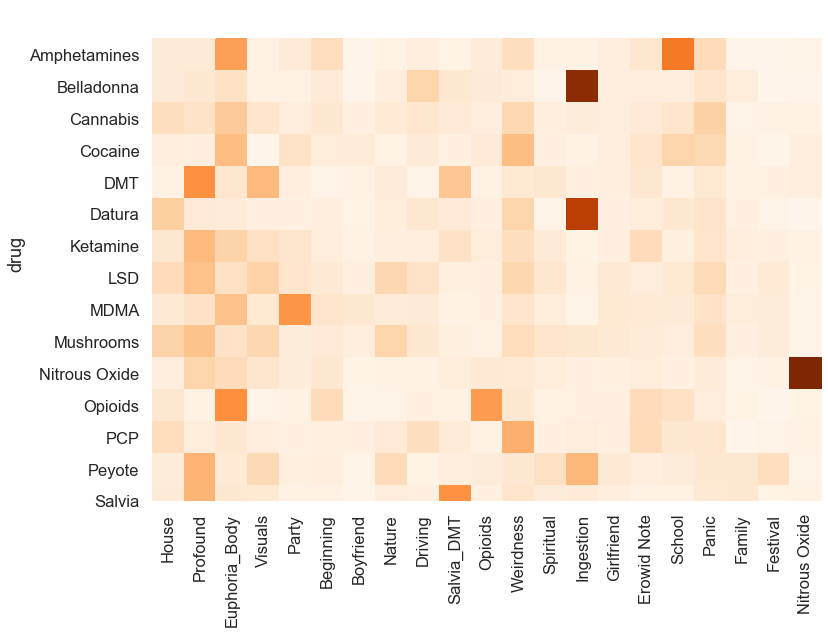

In [42]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(drug_topic_agg, square=True, fmt='g', cmap='Oranges', cbar=False)
ax.set_ylim(drug_topic_agg.shape[0]-0.5, -1)

(14.5, -1)

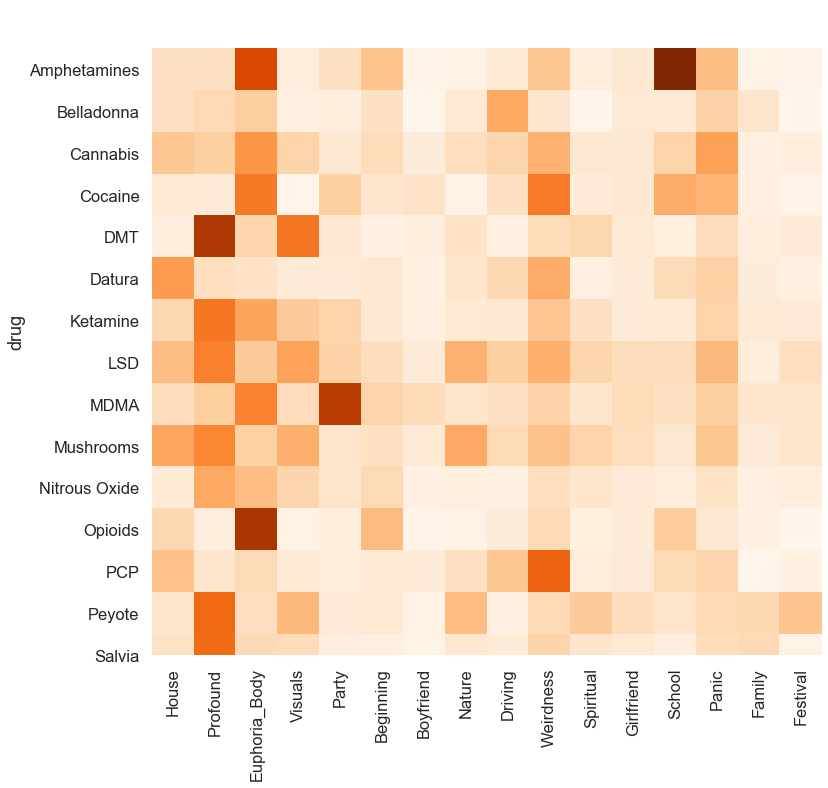

In [44]:
# Heatmap dropping less interesting columns

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(drug_topic_agg.drop(labels=['Ingestion', 'Salvia_DMT', 'Opioids', 'Erowid Note', 'Nitrous Oxide'], axis=1), 
            square=True, fmt='g', cmap='Oranges', cbar=False)
ax.set_ylim(drug_topic_agg.shape[0]-0.5, -1)

## Word Clouds

In [45]:
# Function for building dictionary with topic words as keys
# and frequencies as values

def get_word_freq(topic, model, n_top_words, vocab):
    
    # the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    
    word_dict = {};
        
    # for each topic, obtain the largest values of word topic prob 
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    
    # index of top words
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    
    # list of top freq words
    words = [vocab[key] for key in words_ids]
    
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict

In [202]:
def make_clouds(model, count_matrix, topic_names, colormap='gist_rainbow', background='black'):
    """
    Make word cloud for each topic.
    
    model = nmf or lda
    count_matrix = CountVectorizer or TfIdf output
    topic_names = list of names equal in length to components in model
    """
    for ix, topic in enumerate(topic_names):
        word_dict = get_word_freq(ix, model, 30, count_matrix.get_feature_names())
        plt.figure(figsize = (16, 20))
        wc = WordCloud(background_color=background, width=800, height=600, colormap=colormap)
        plt.imshow(wc.fit_words(word_dict), interpolation='bilinear')
        plt.axis('off')
        plt.savefig('figs/word_cloud_' + topic + '_' + background + '.png', bbox_inches='tight')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


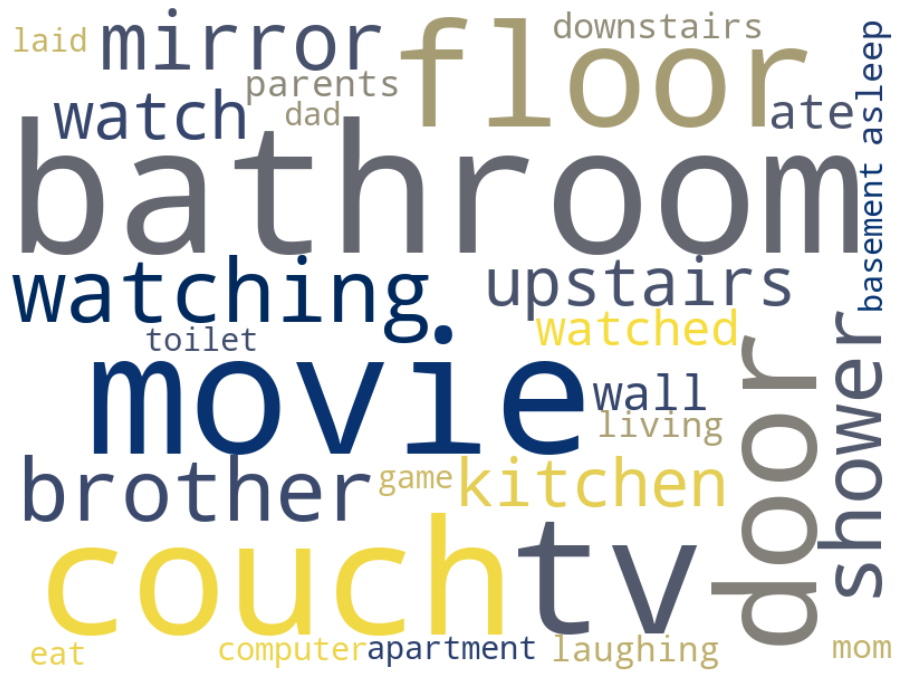

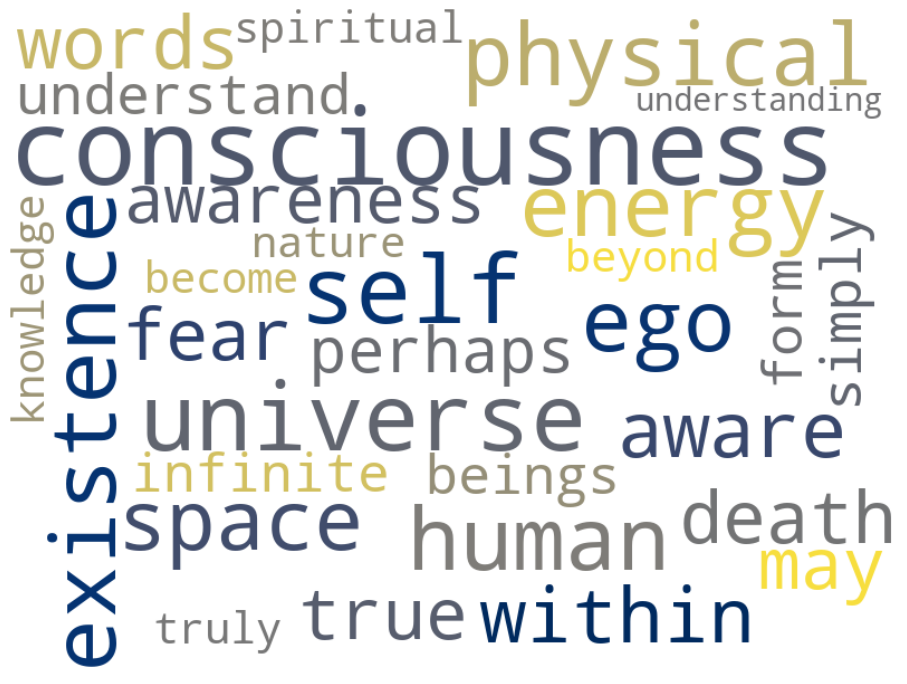

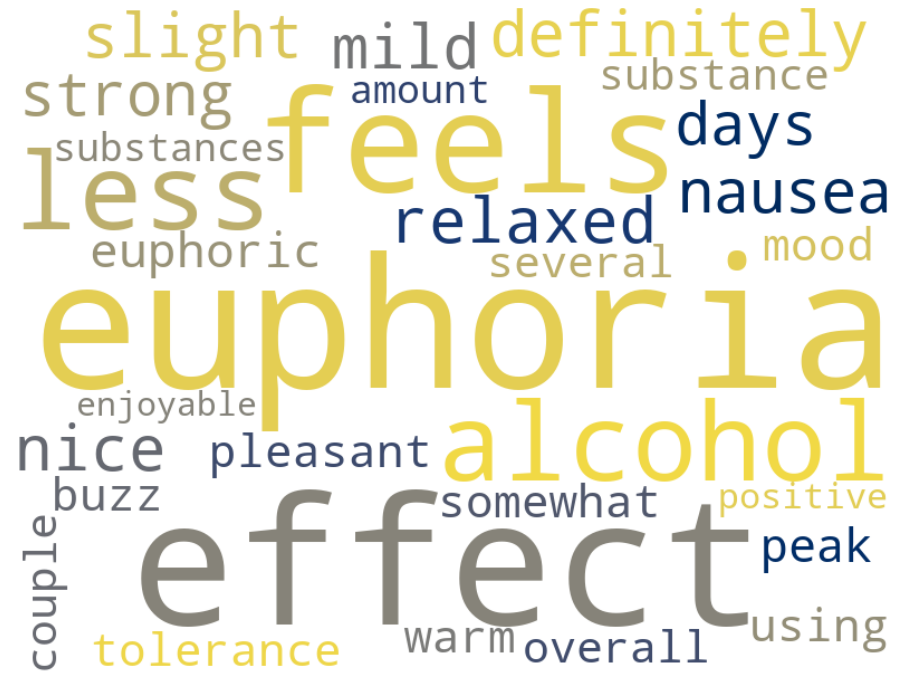

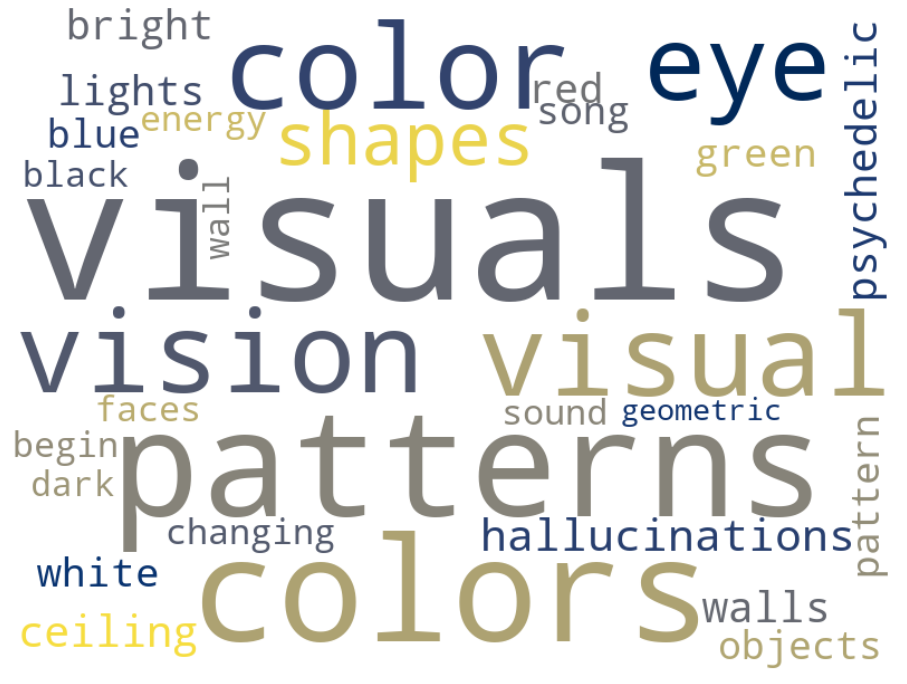

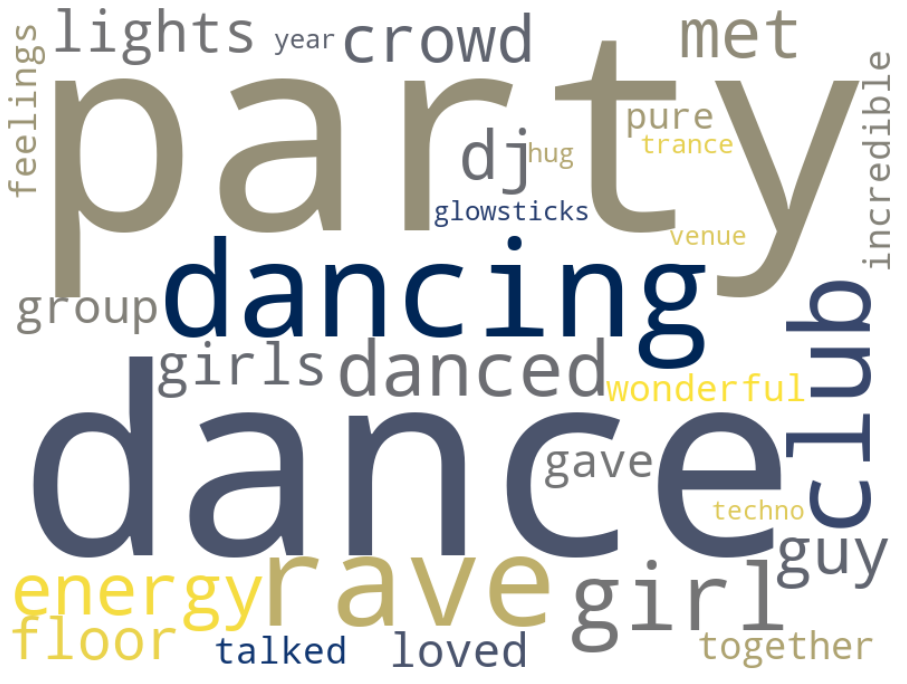

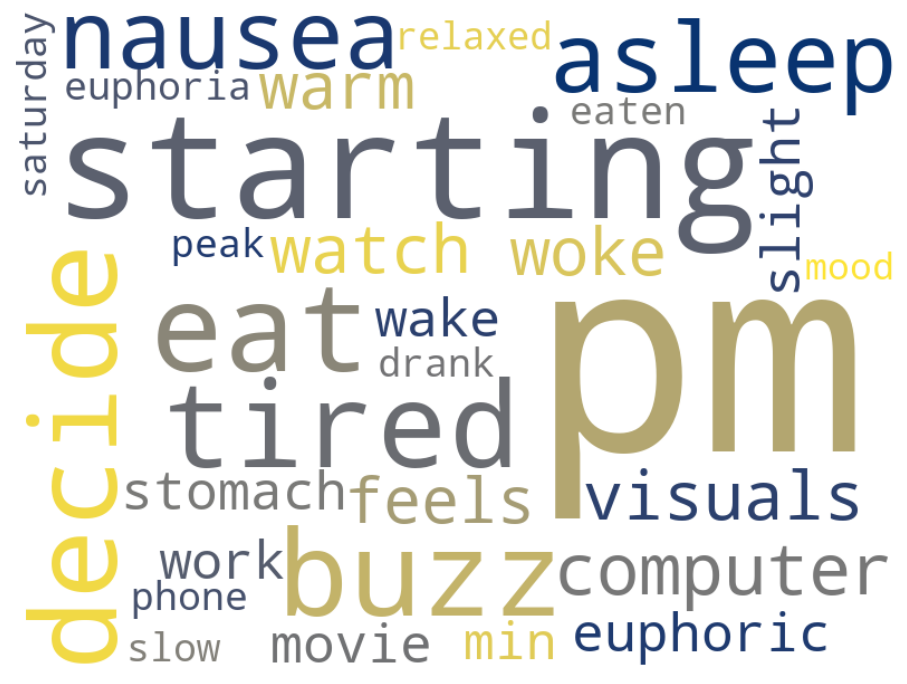

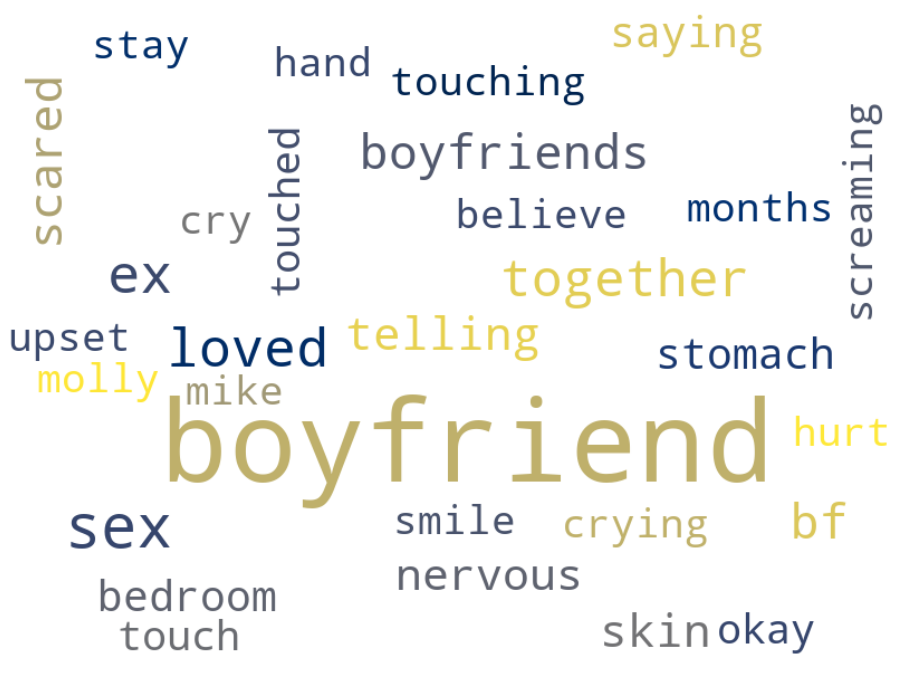

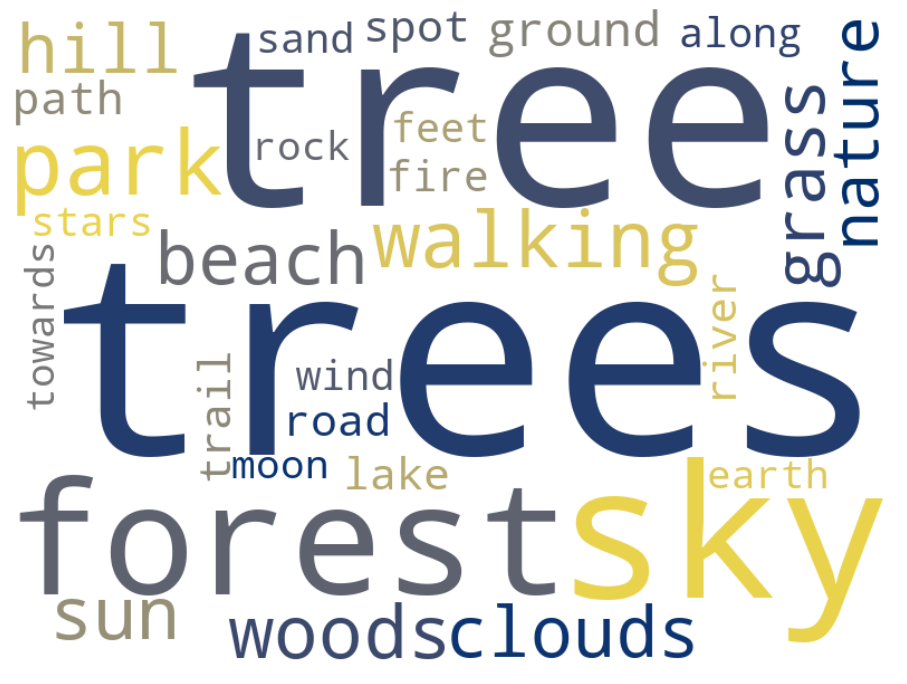

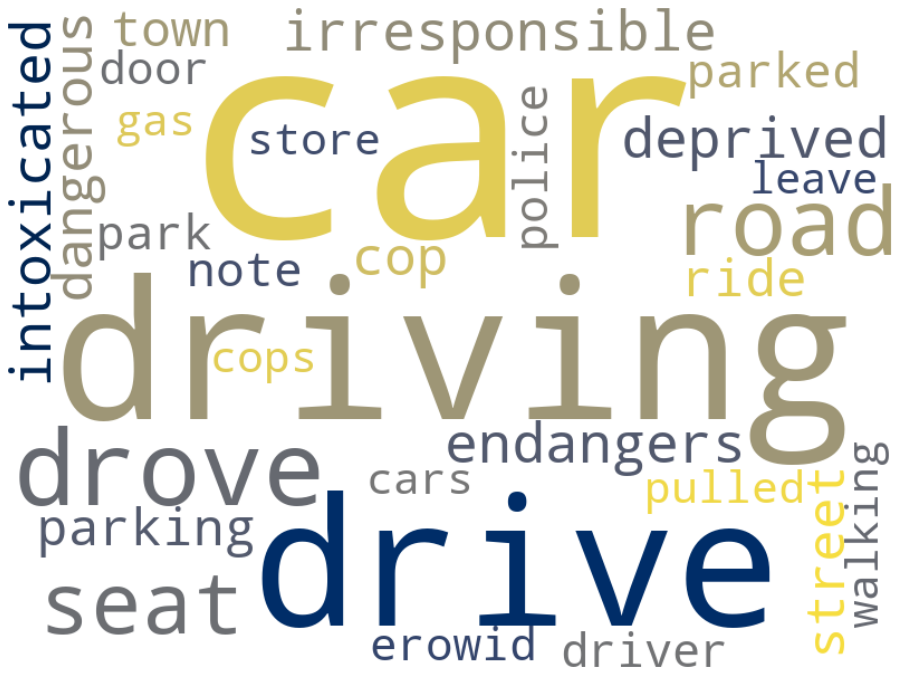

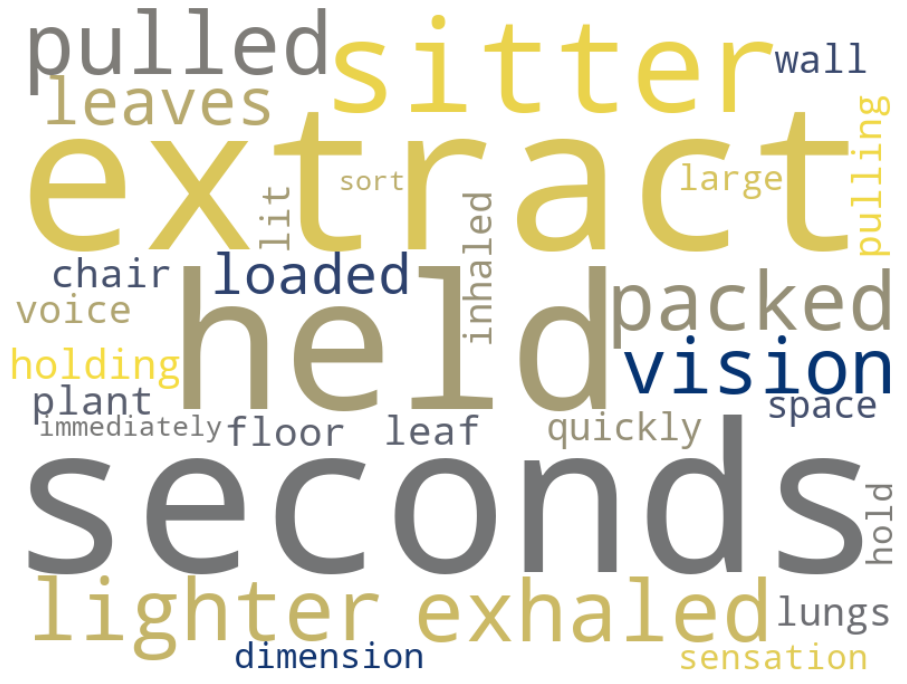

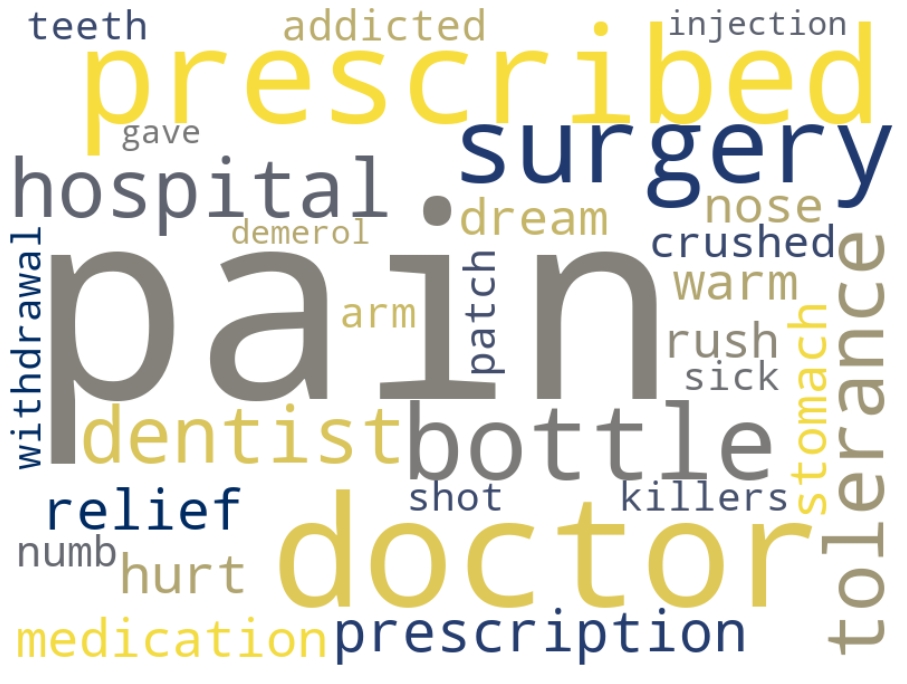

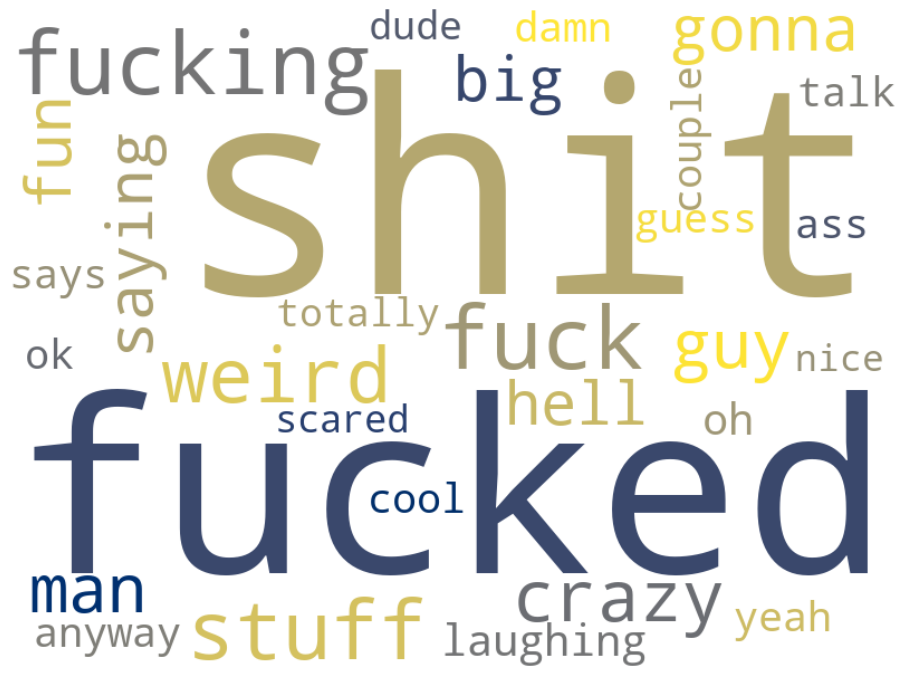

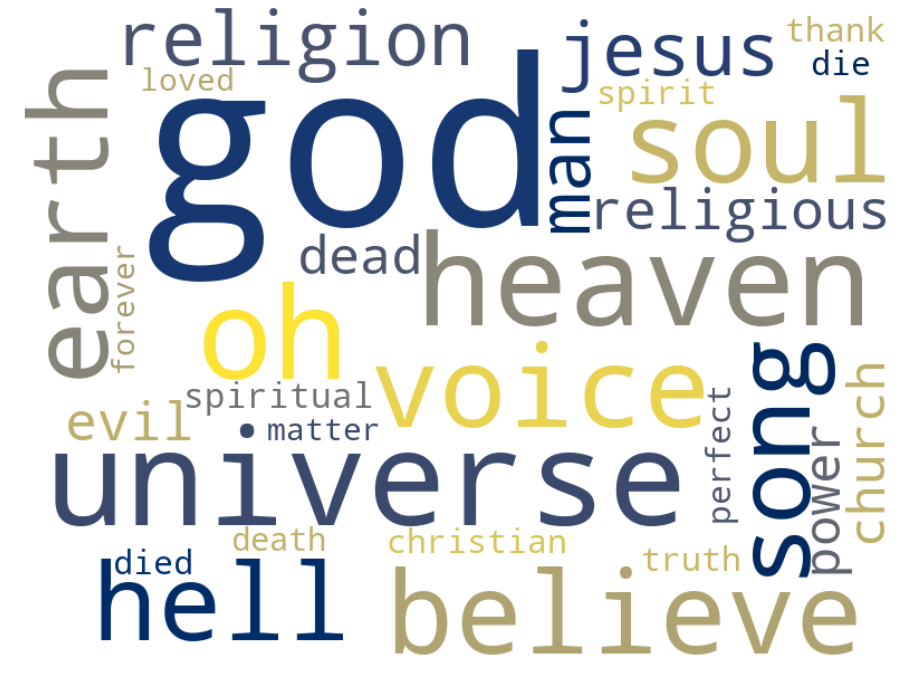

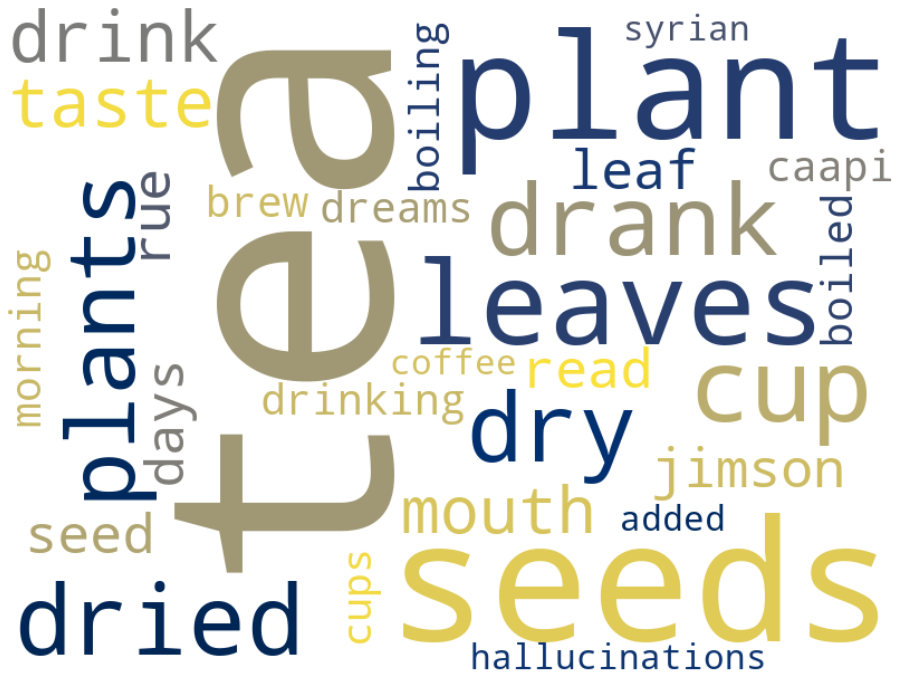

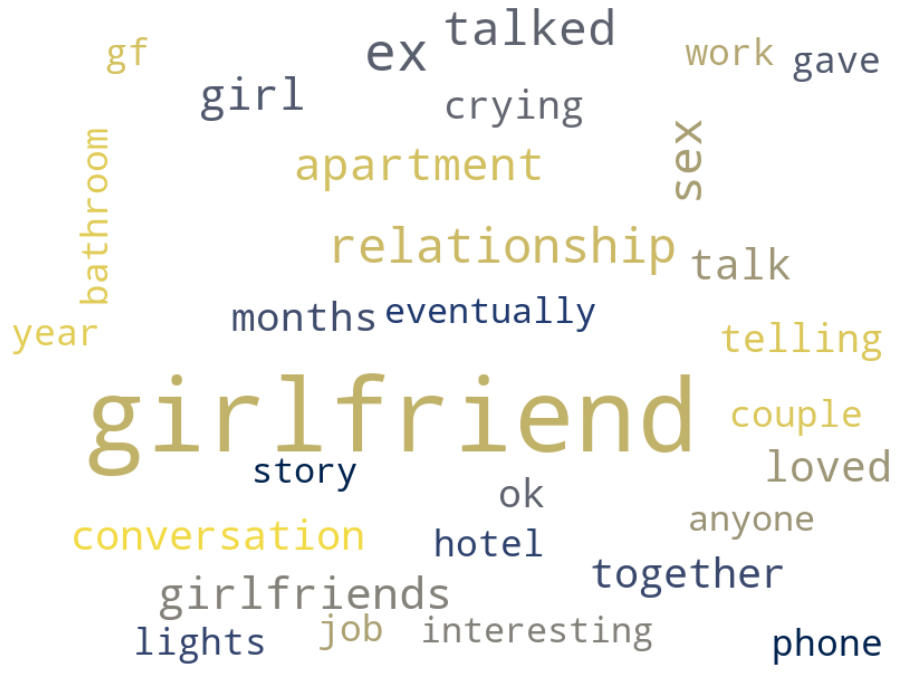

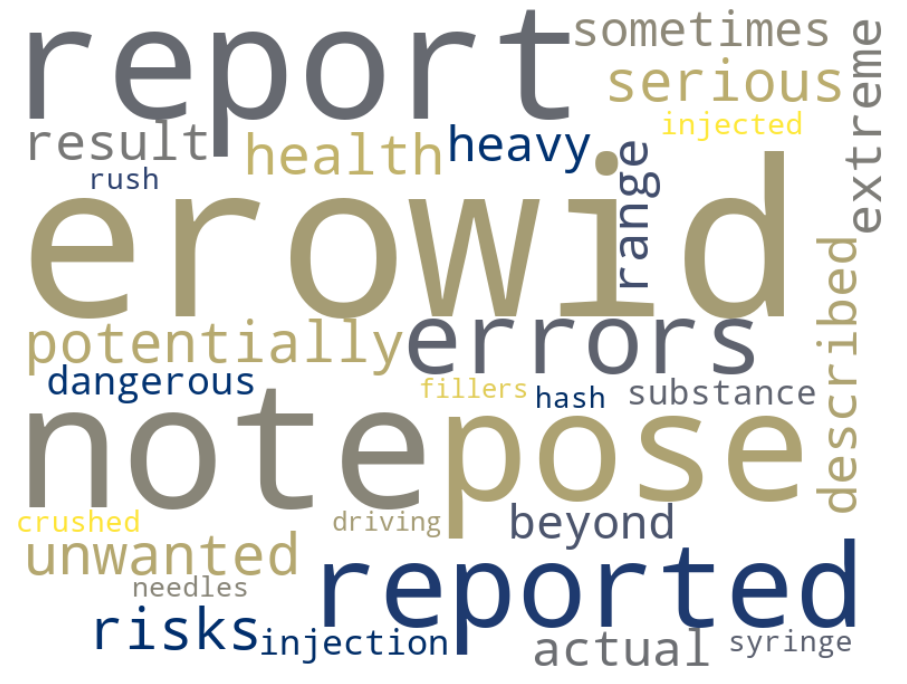

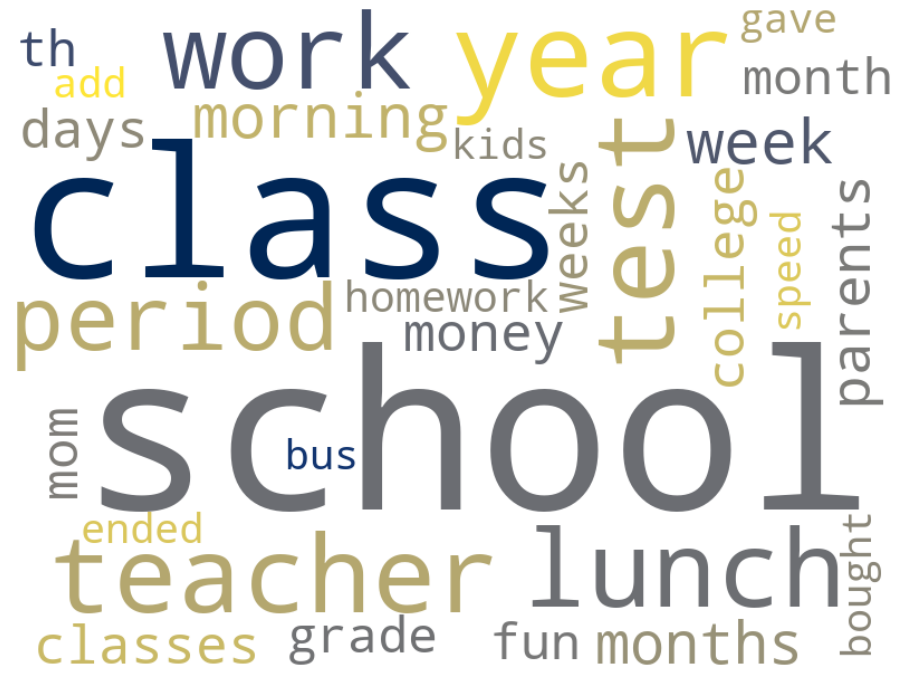

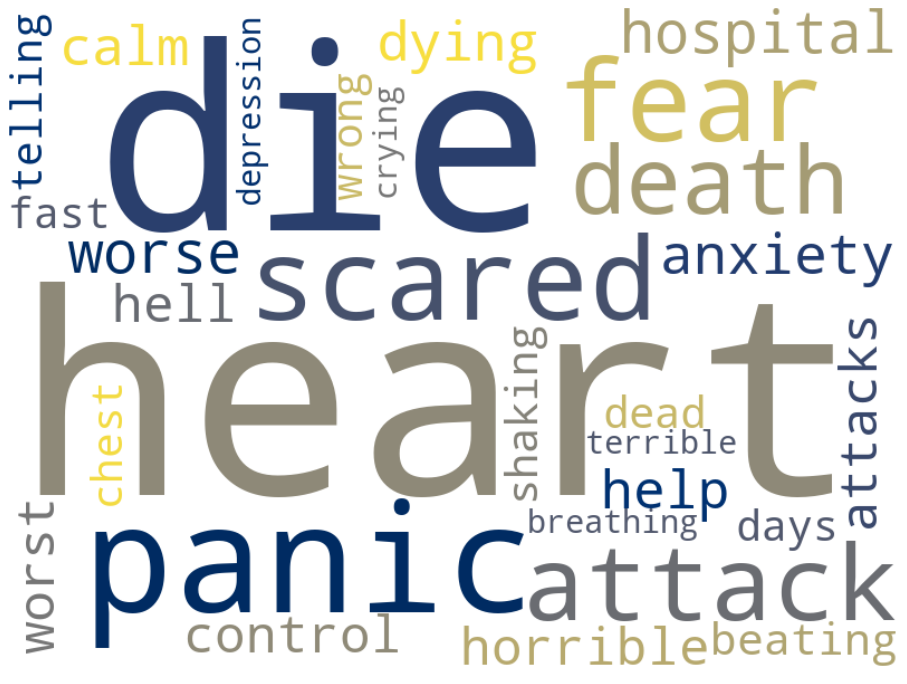

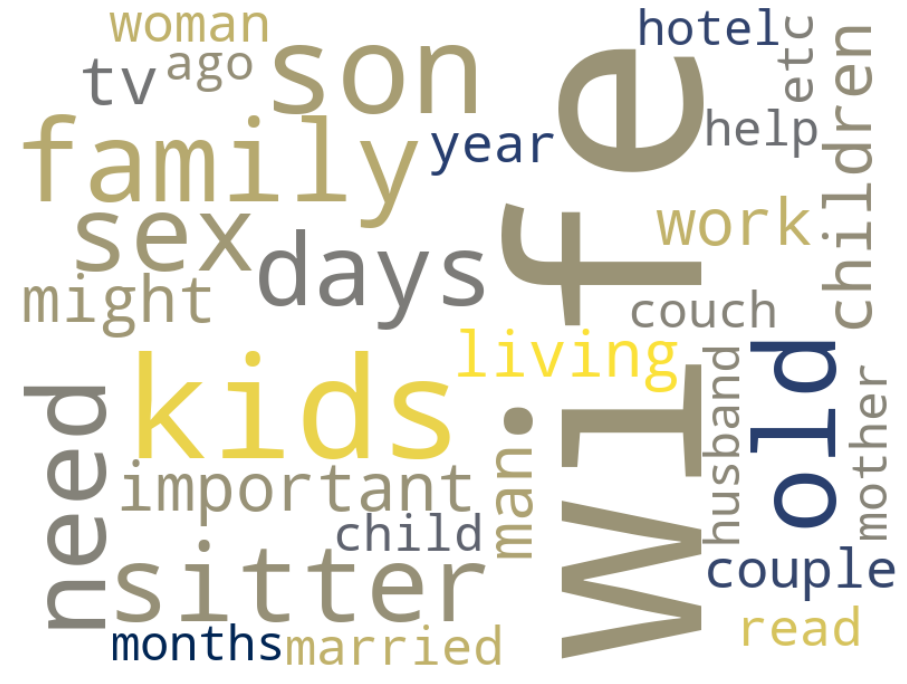

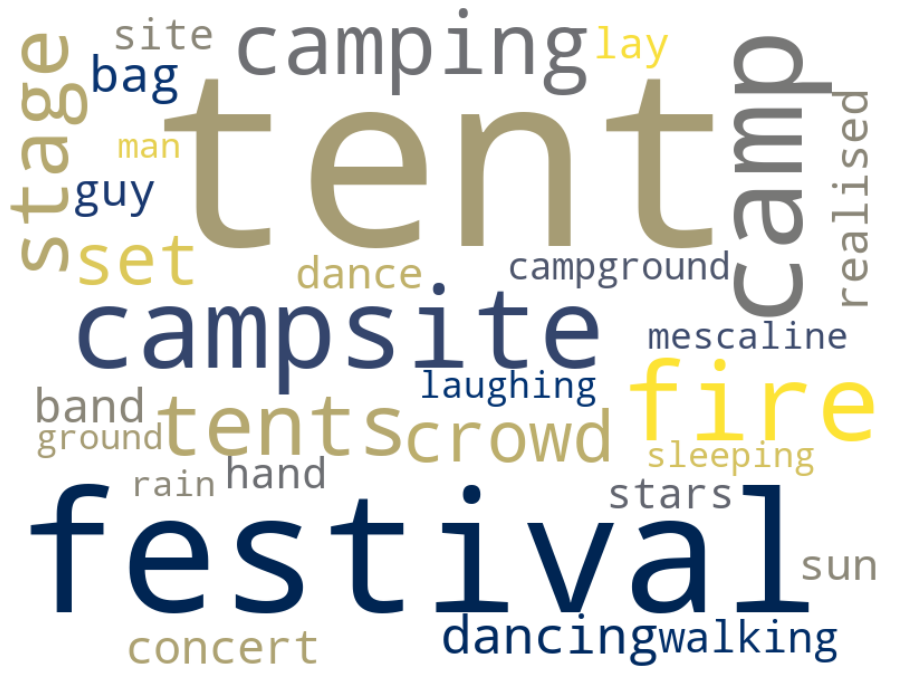

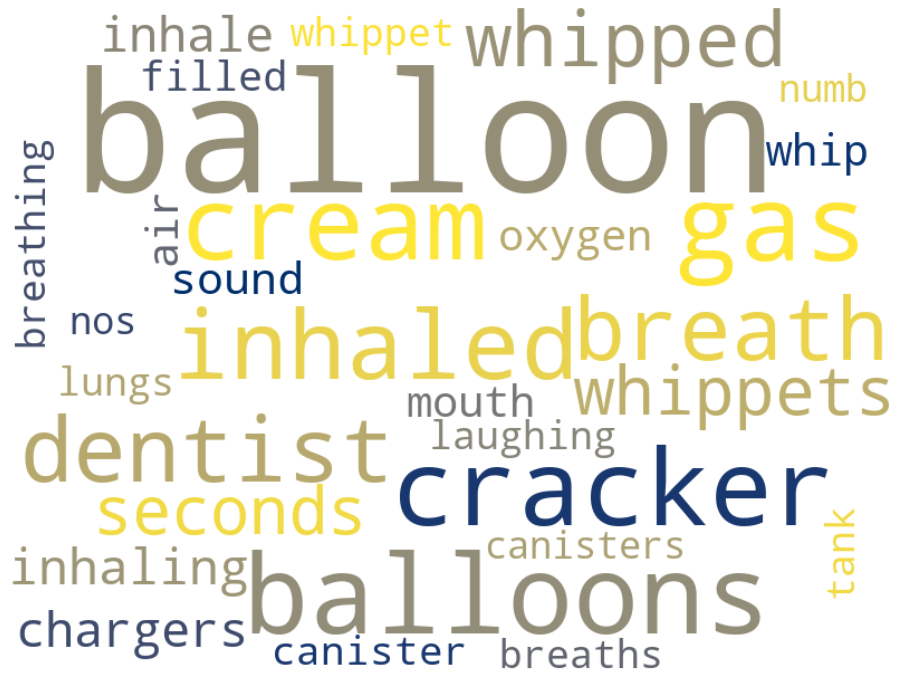

In [203]:
make_clouds(nmf_full, tf_full, topic_names, colormap='cividis', background='white')

In [54]:
def get_doc_topics(doc_topic_prob):
    # Return list of topics for documents, given doc topic distribution
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_prob)]

## Plot distribution of drugs per topic

In [49]:
drug_topic_agg.head()

House  Profound  Euphoria_Body   Visuals     Party  \
drug                                                                  
Amphetamines  0.006657  0.006796  0.031443       0.003102  0.006927   
Belladonna    0.006756  0.008425  0.011149       0.002350  0.002921   
Cannabis      0.012102  0.010710  0.019763       0.010015  0.005062   
Cocaine       0.004386  0.003964  0.023820       0.000681  0.010744   
DMT           0.003035  0.035824  0.009230       0.024449  0.004801   

              Beginning  Boyfriend    Nature   Driving  Salvia_DMT   Opioids  \
drug                                                                           
Amphetamines  0.012641   0.000972   0.001788  0.004669  0.001773    0.006370   
Belladonna    0.006885   0.000296   0.004461  0.016681  0.008056    0.006599   
Cannabis      0.008017   0.003407   0.007315  0.009265  0.007073    0.004545   
Cocaine       0.005549   0.006288   0.001800  0.006788  0.003483    0.006957   
DMT           0.002051   0.002593   0.006352  0.002014  0.021327    0.002889   

              Weirdness  Spiritual  Ingestion  Girlfriend  Erowid Note  \
drug                                                                     
Amphetamines  0.012087   0.002630   0.002972   0.004790    0.009291      
Belladonna    0.005639   0.000920   0.070342   0.004408    0.004801      
Cannabis      0.015269   0.004685   0.005767   0.004992    0.006924      
Cocaine       0.023604   0.003811   0.002536   0.004738    0.010124      
DMT           0.007973   0.009064   0.003931   0.004586    0.009116      

                School     Panic    Family  Festival  Nitrous Oxide  
drug                                                                 
Amphetamines  0.041798  0.013519  0.001122  0.001071  0.001675       
Belladonna    0.004465  0.010216  0.005683  0.000316  0.001093       
Cannabis      0.009766  0.017871  0.002142  0.002637  0.003004       
Cocaine       0.016320  0.015013  0.002402  0.001352  0.004351       
DMT           0.002440  0.007789  0.002819  0.003628  0.004476

In [200]:
def plot_topic_dists(drug_topic_agg, pal='cividis_r'):
    """
    For each topic plot drug proportionality, horizontal bar
    
    df = drugs as rows, topics as columns, aggregated
         topic frequencies in each cell
    
    pal = matplotlib color palette
    """
    
    # Normalize each row by row sum first
    drug_topic_agg_normed = drug_topic_agg.div(drug_topic_agg.sum(axis=1), axis=0)
    
    for topic in drug_topic_agg.columns:
        fig, ax = plt.subplots(figsize=(16,16))
        topic_series = drug_topic_agg_normed[topic].sort_values(ascending=False)
        sns.barplot(x=topic_series.values, y=topic_series.index, palette=pal)
        sns.despine()
        #ax.set_title(topic)
        ax.set_ylabel('')
        #ax.set_xlabel('Normed Strength of Topic: ' + topic)
        plt.xlabel(xlabel='Normed Topic Strength', labelpad=15)
        plt.savefig('figs/drug_rep_' + topic + '.png', bbox_inches='tight')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


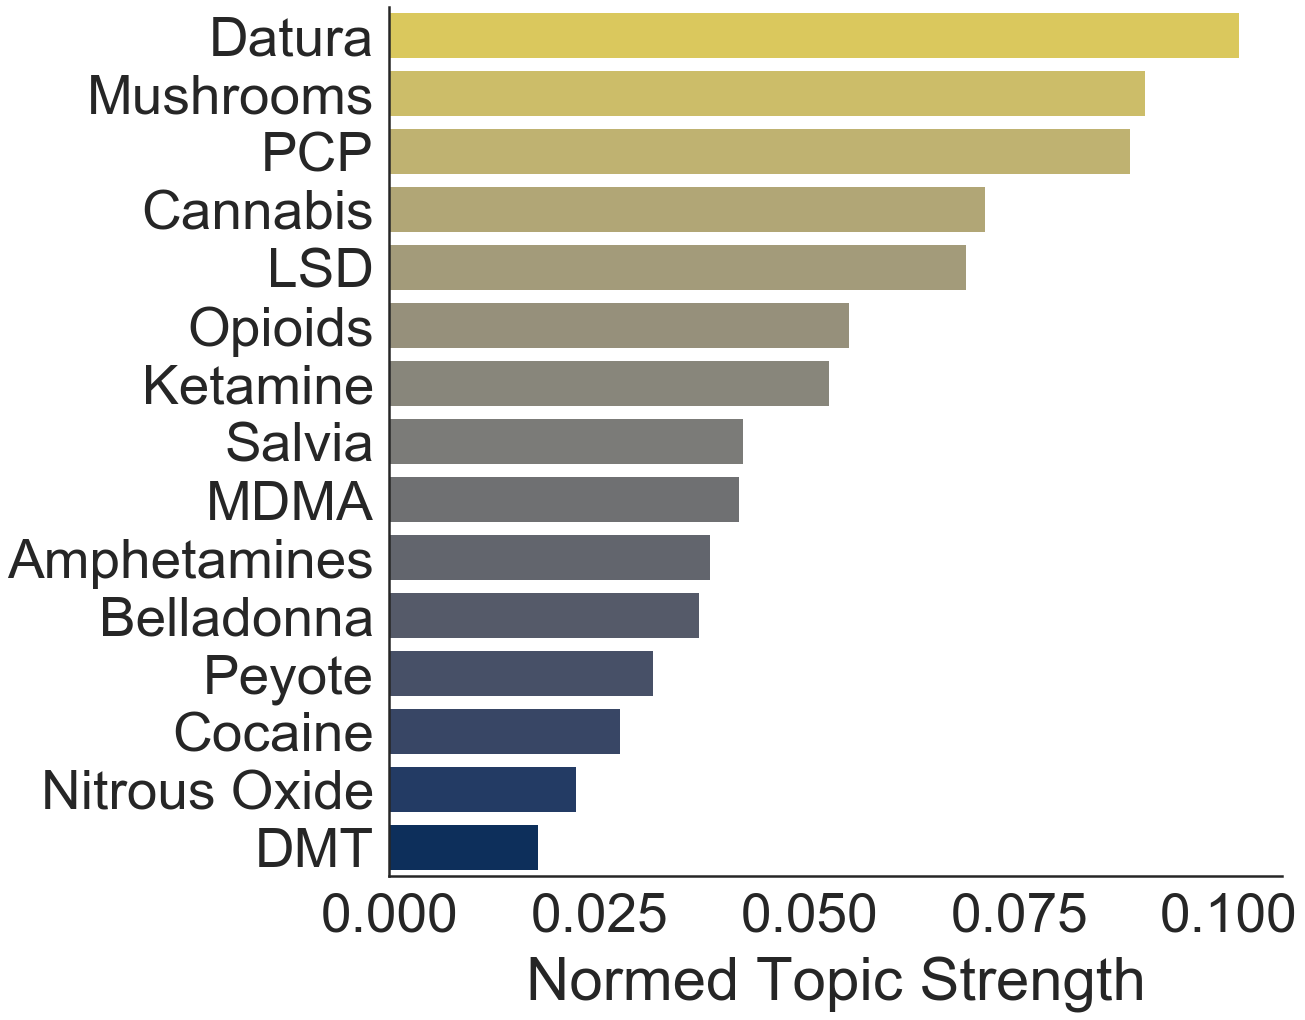

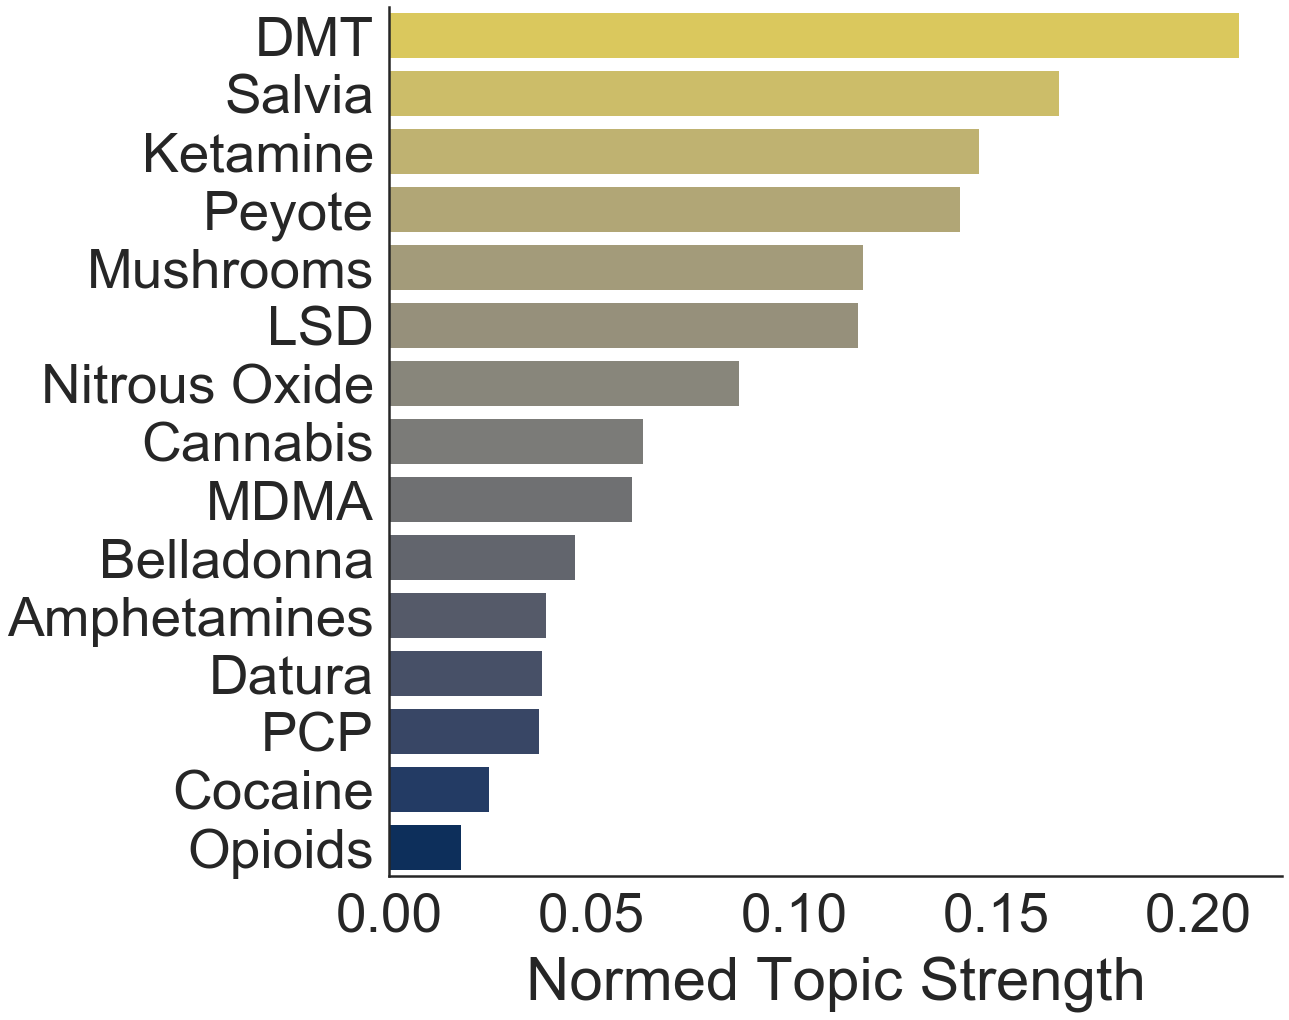

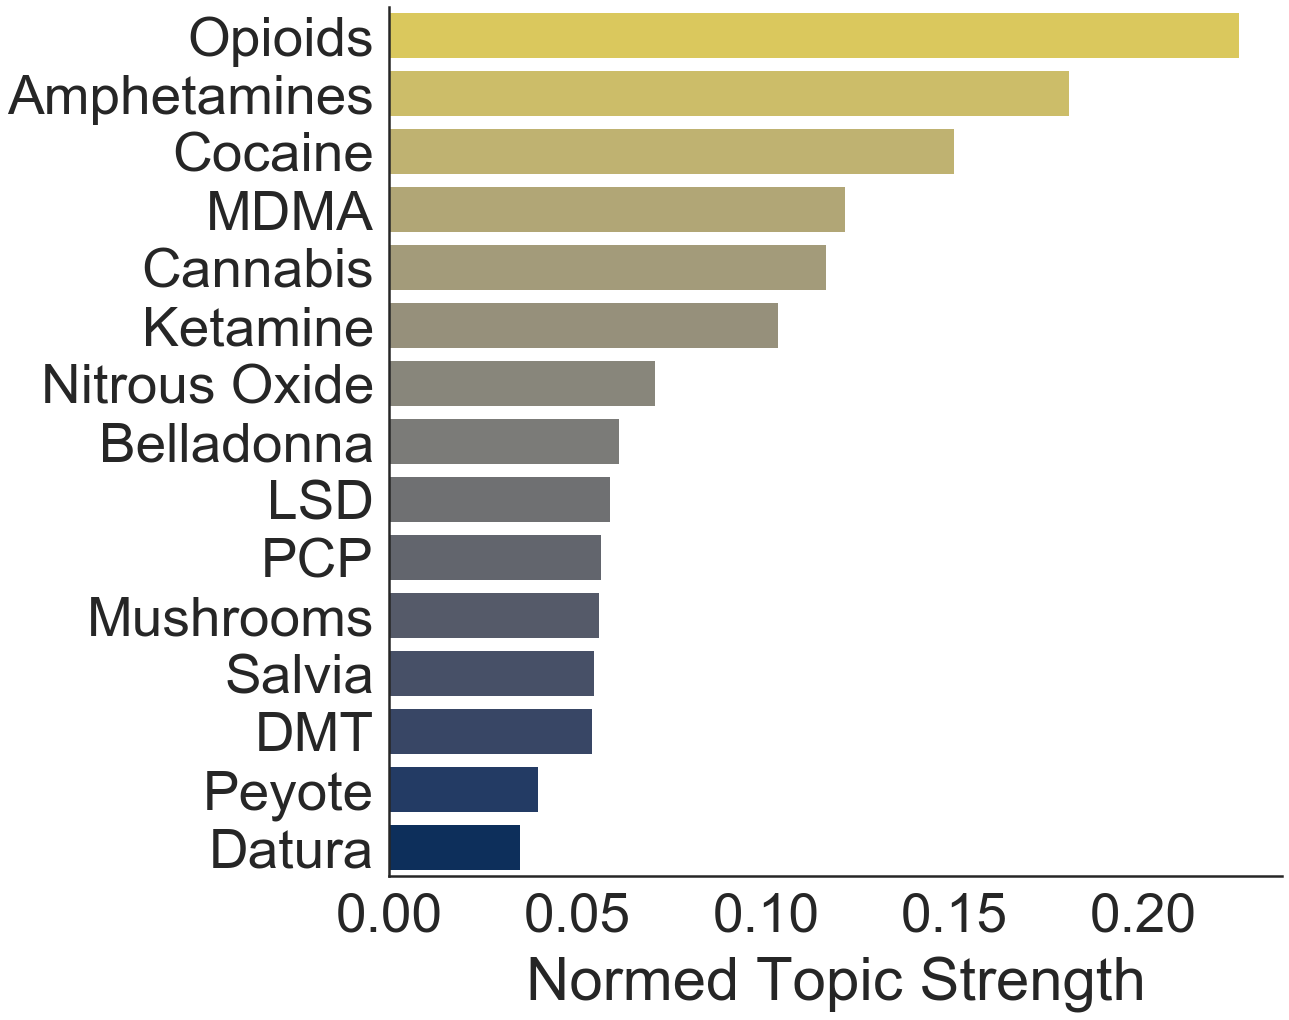

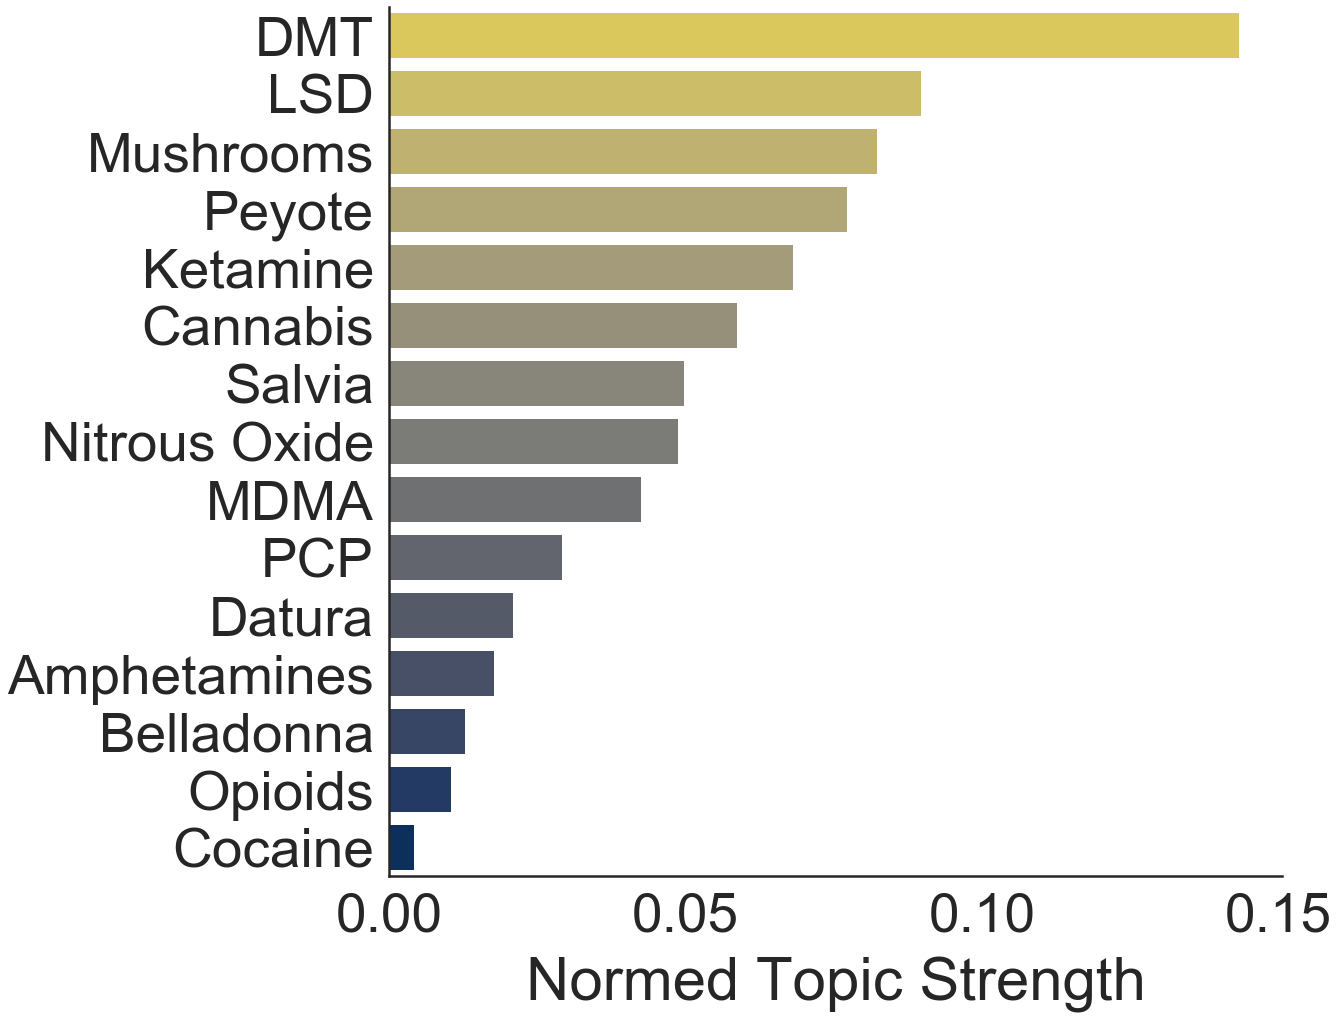

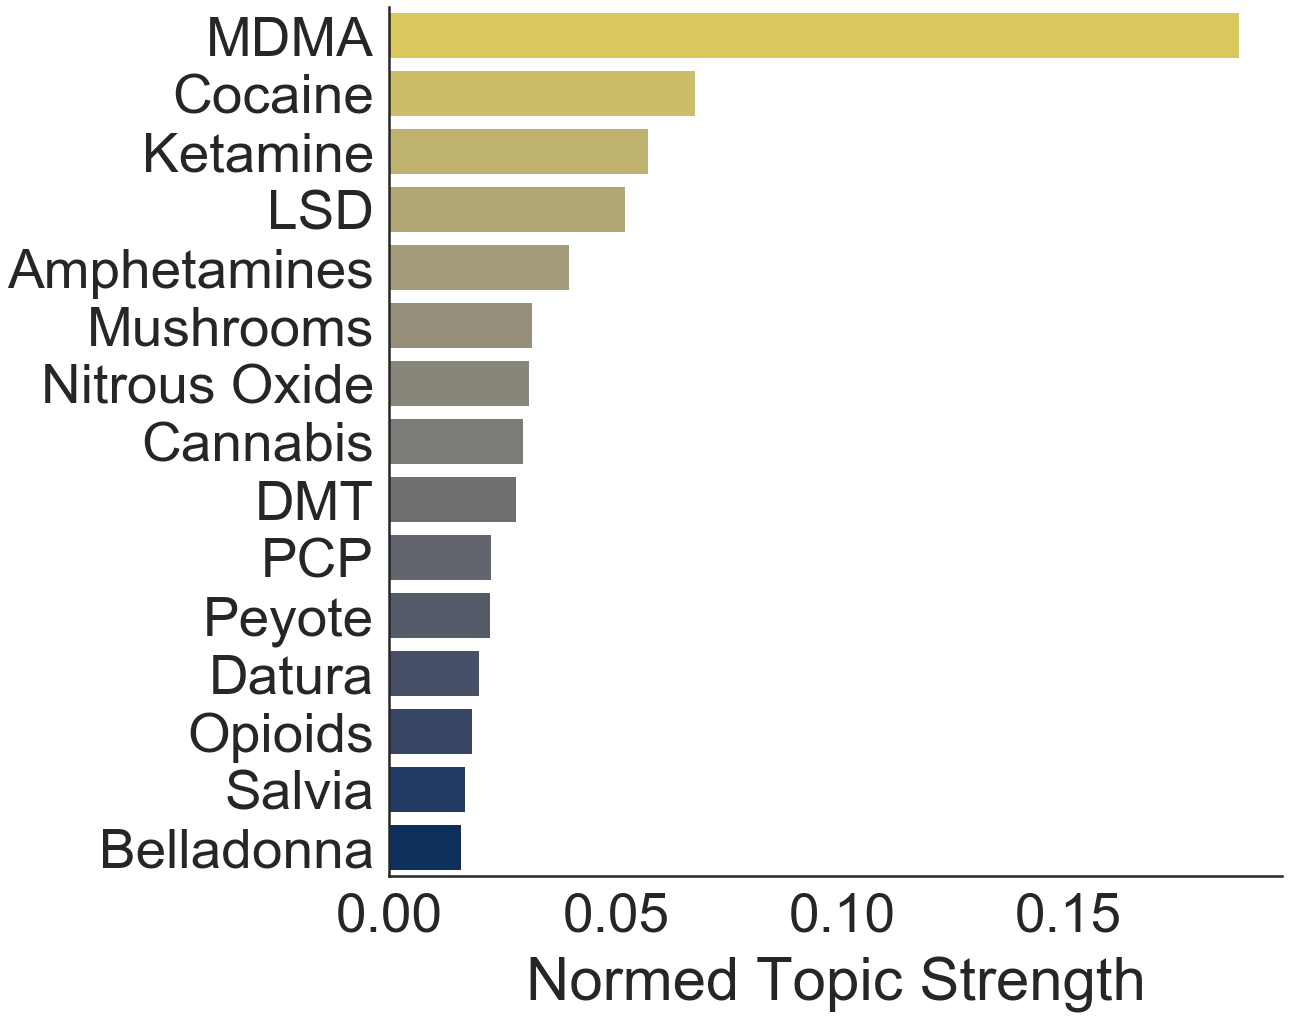

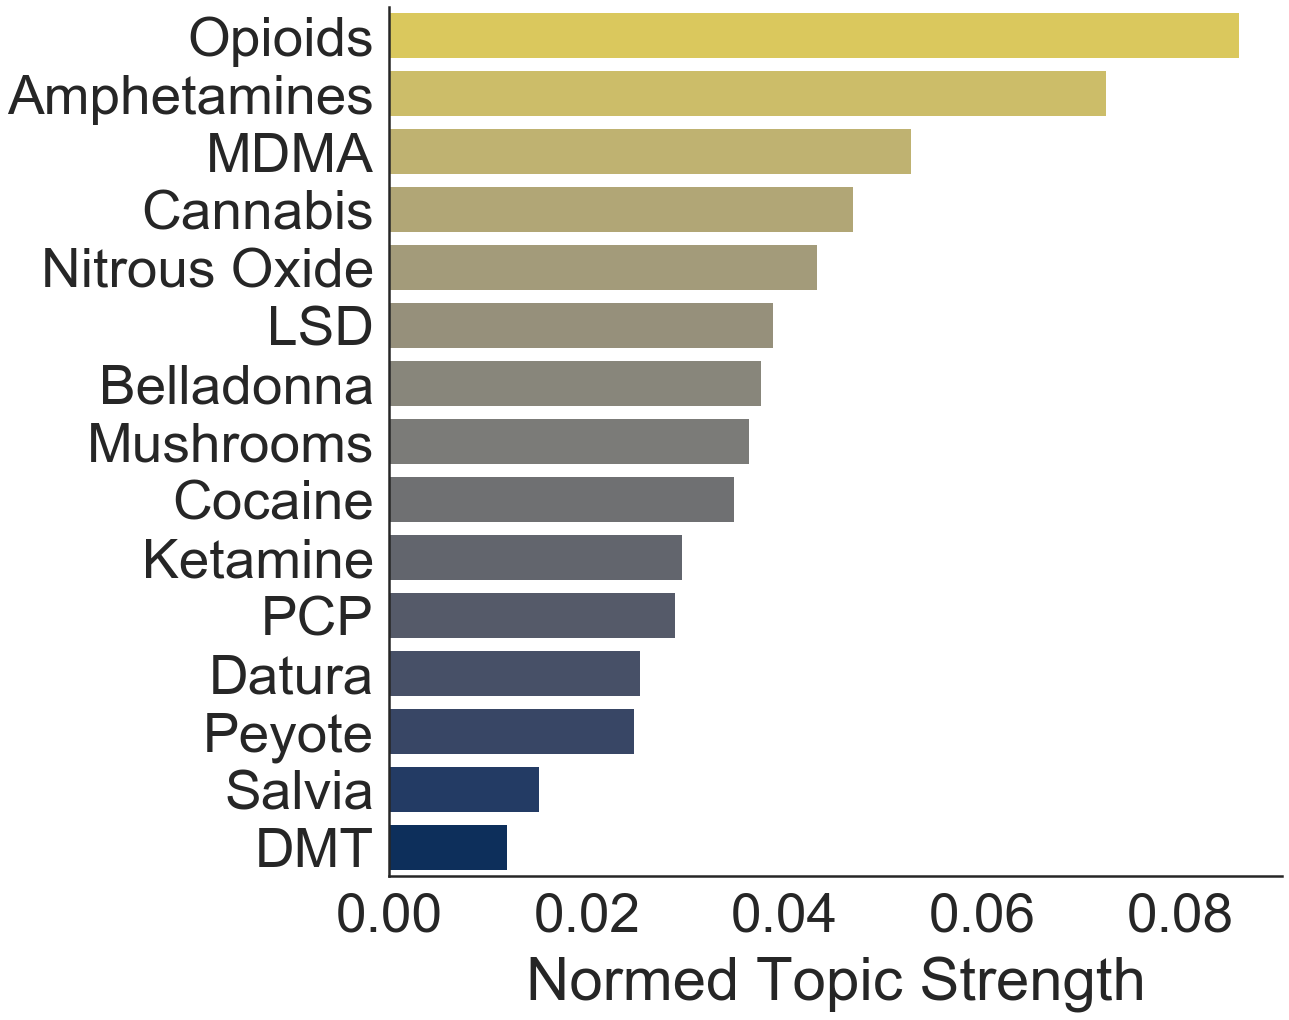

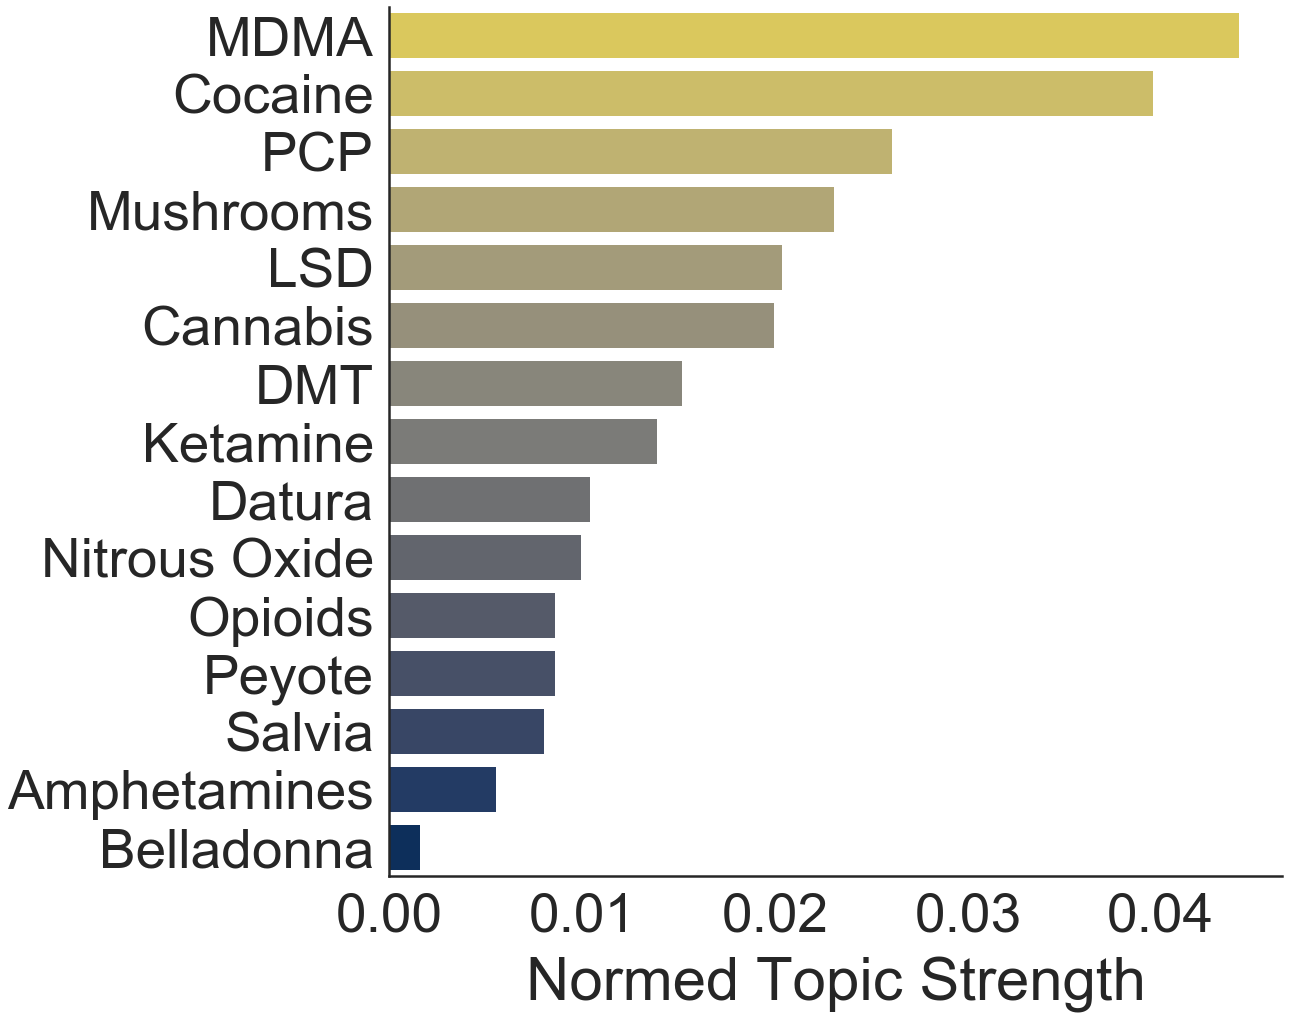

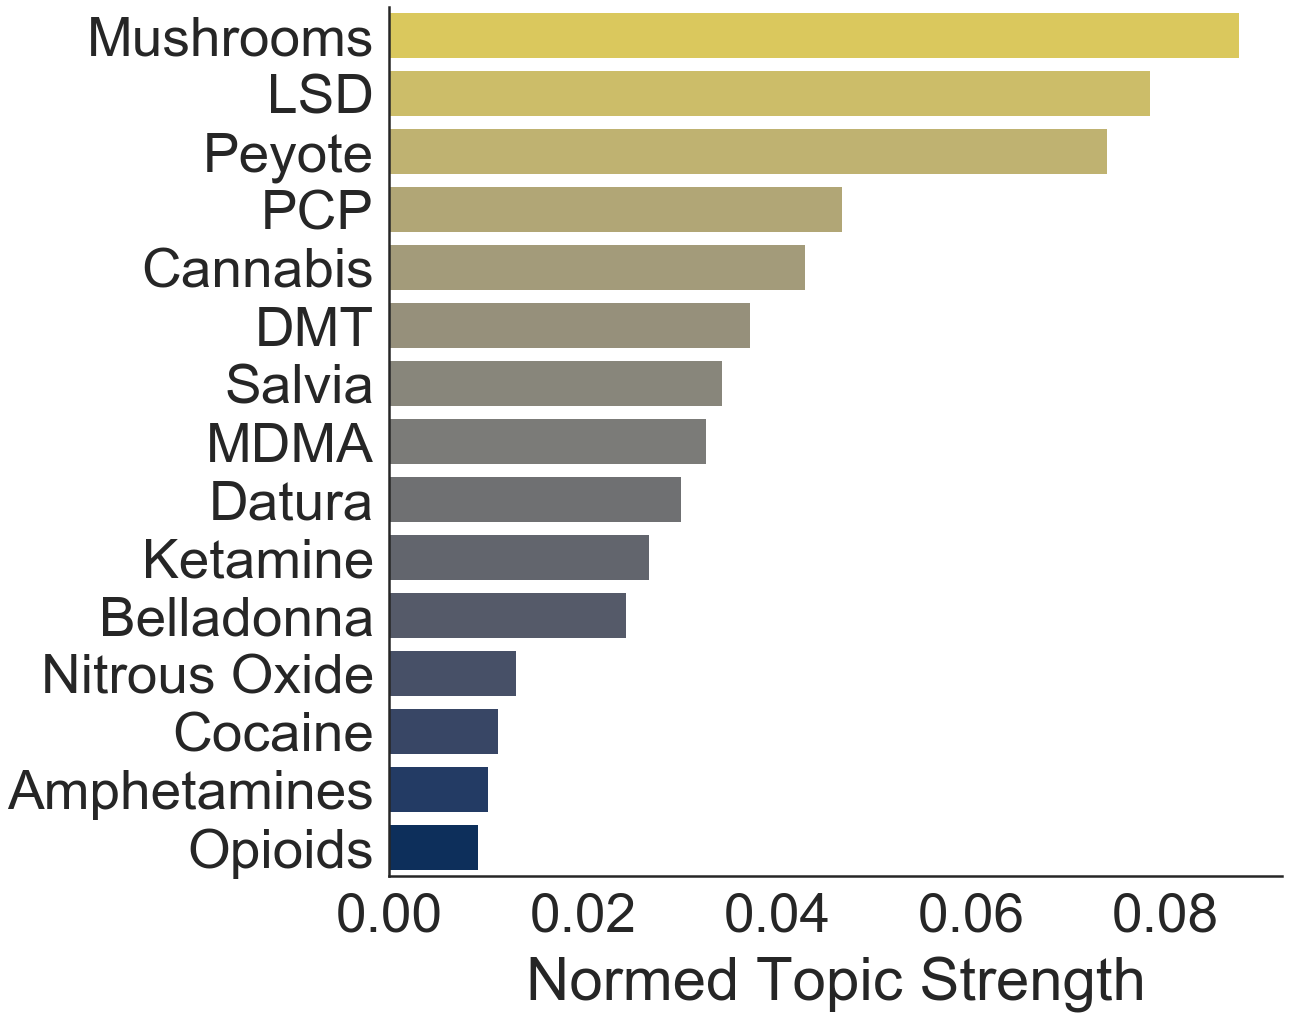

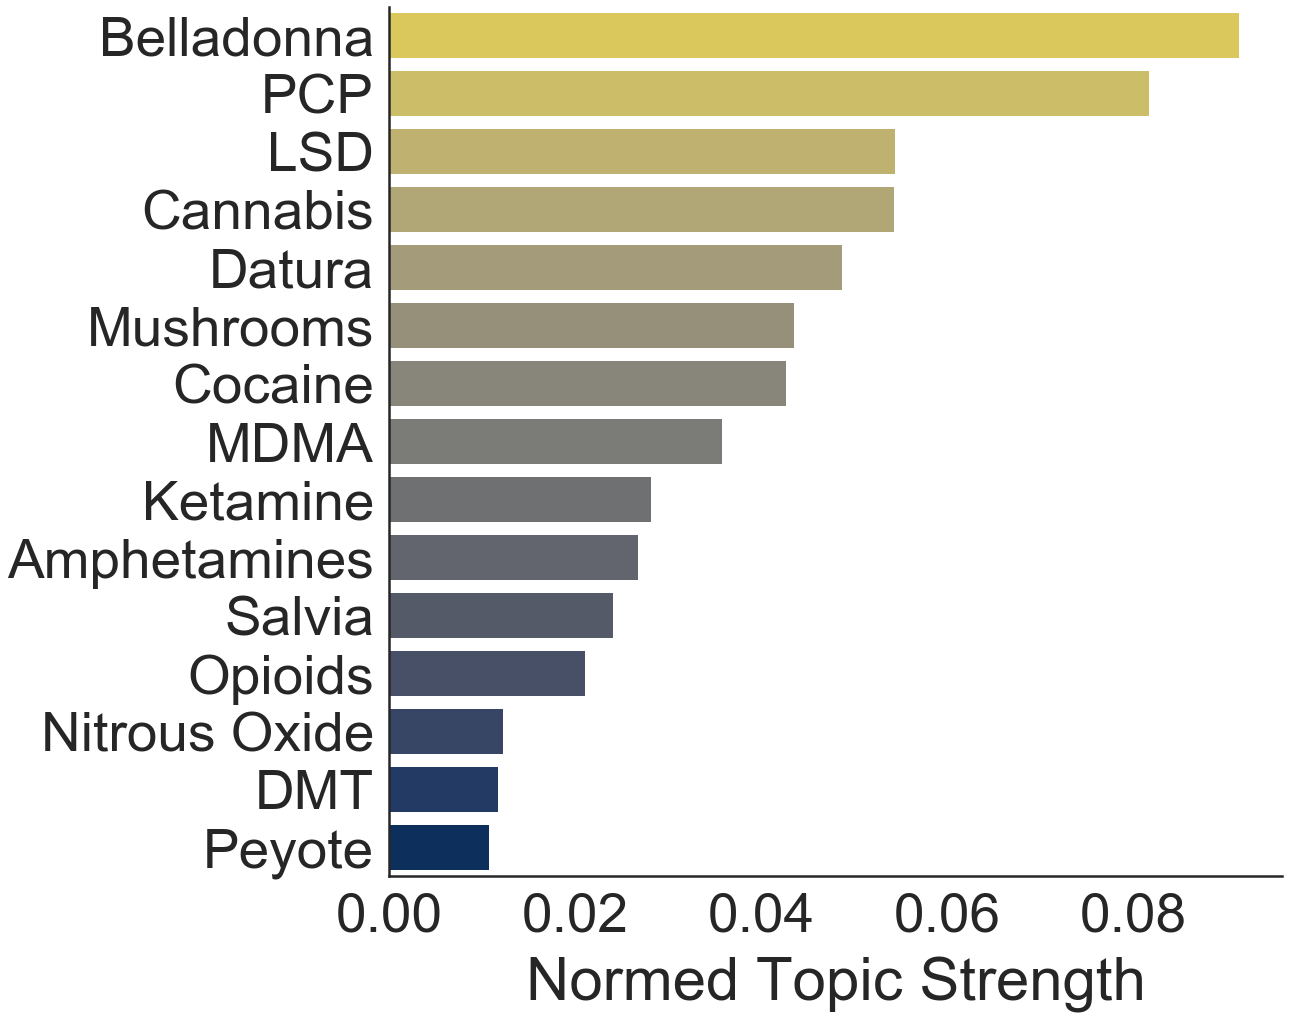

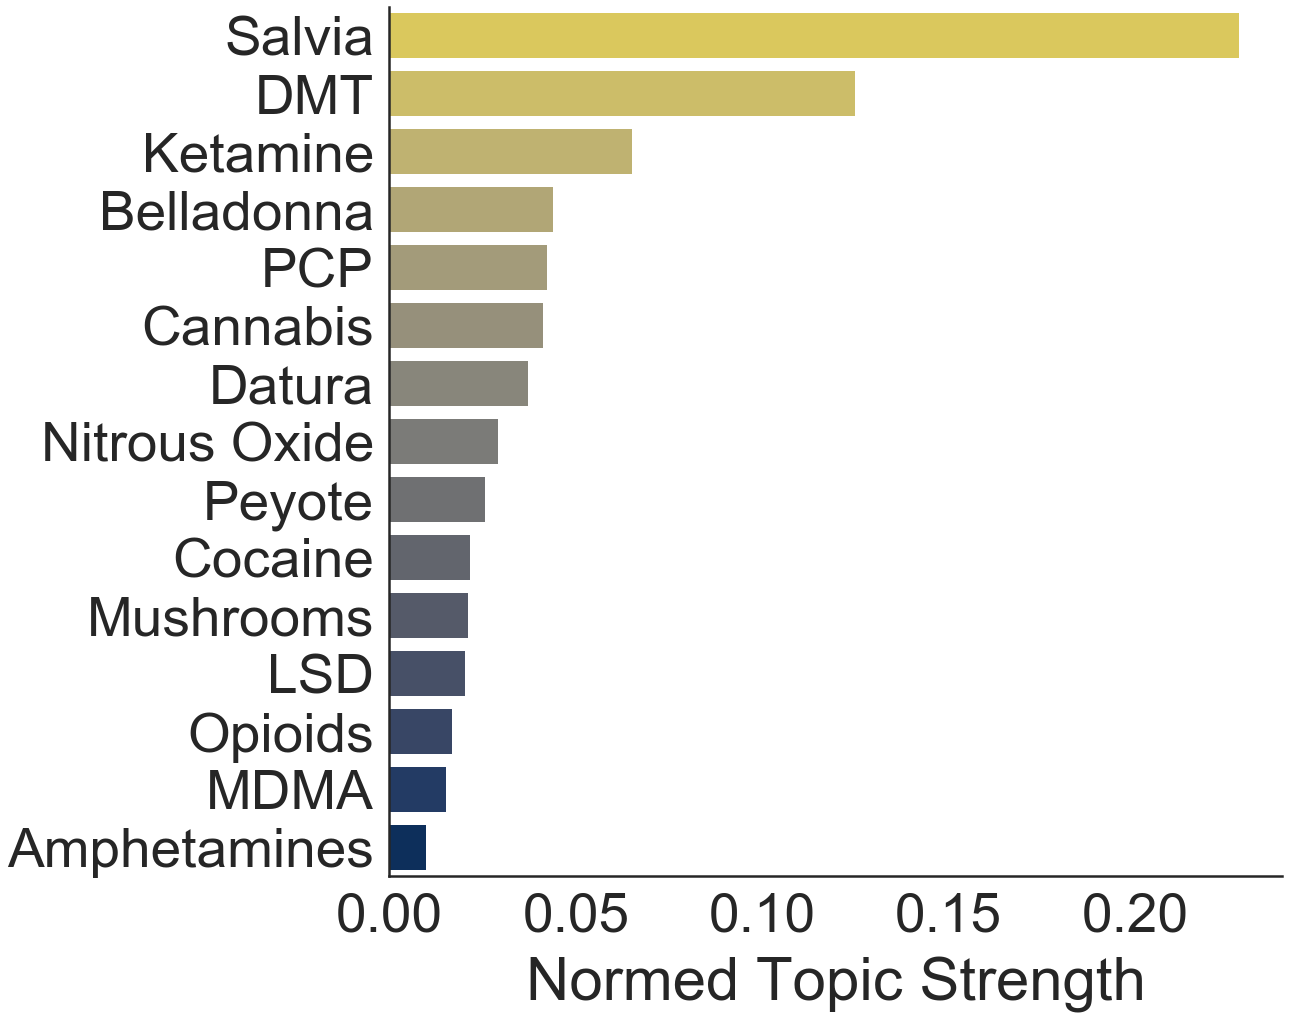

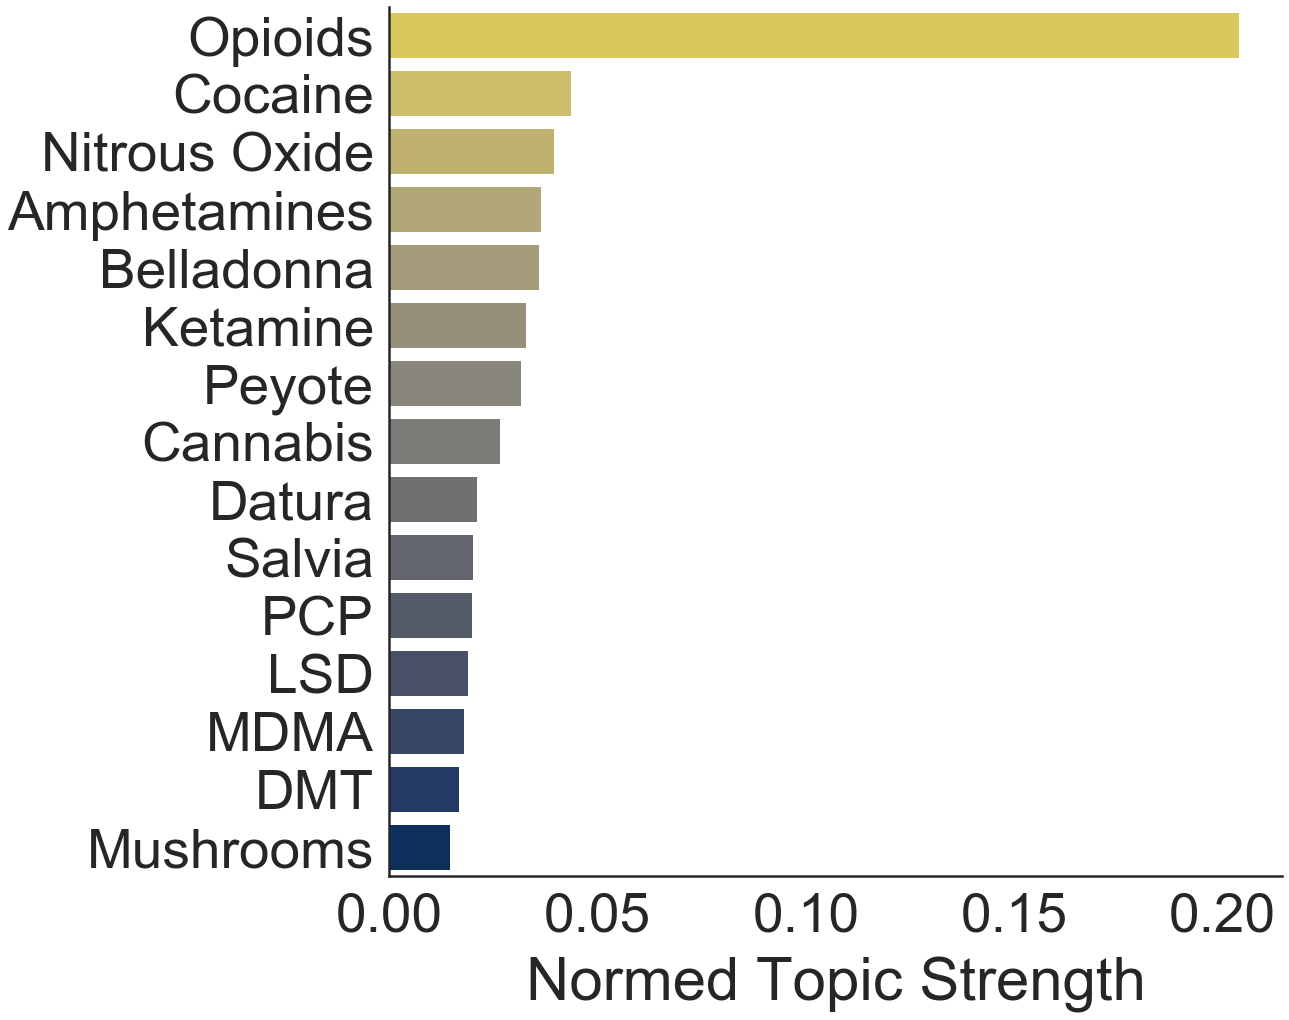

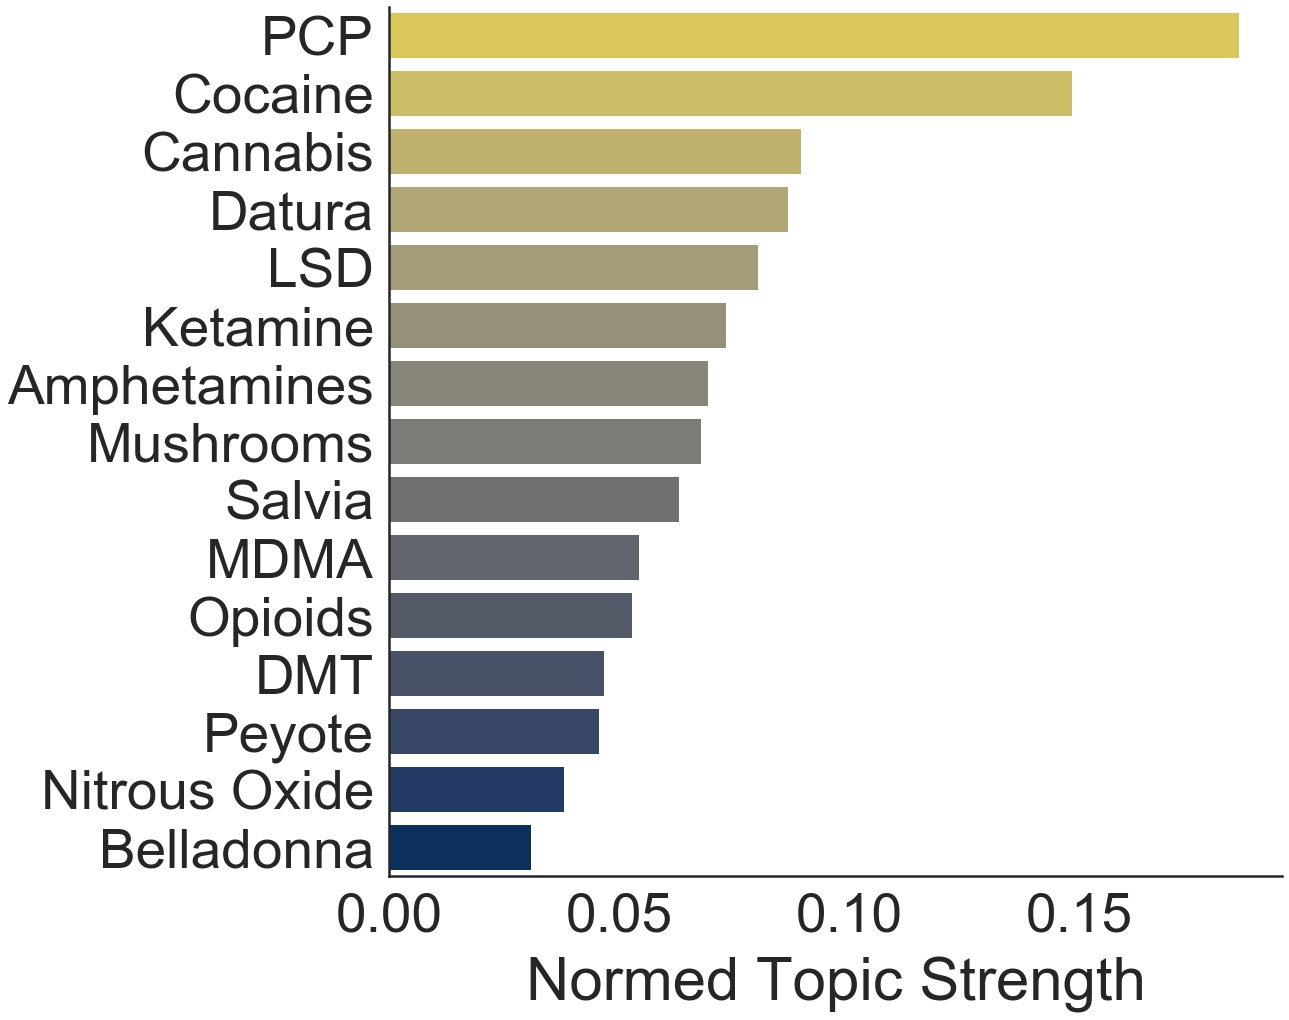

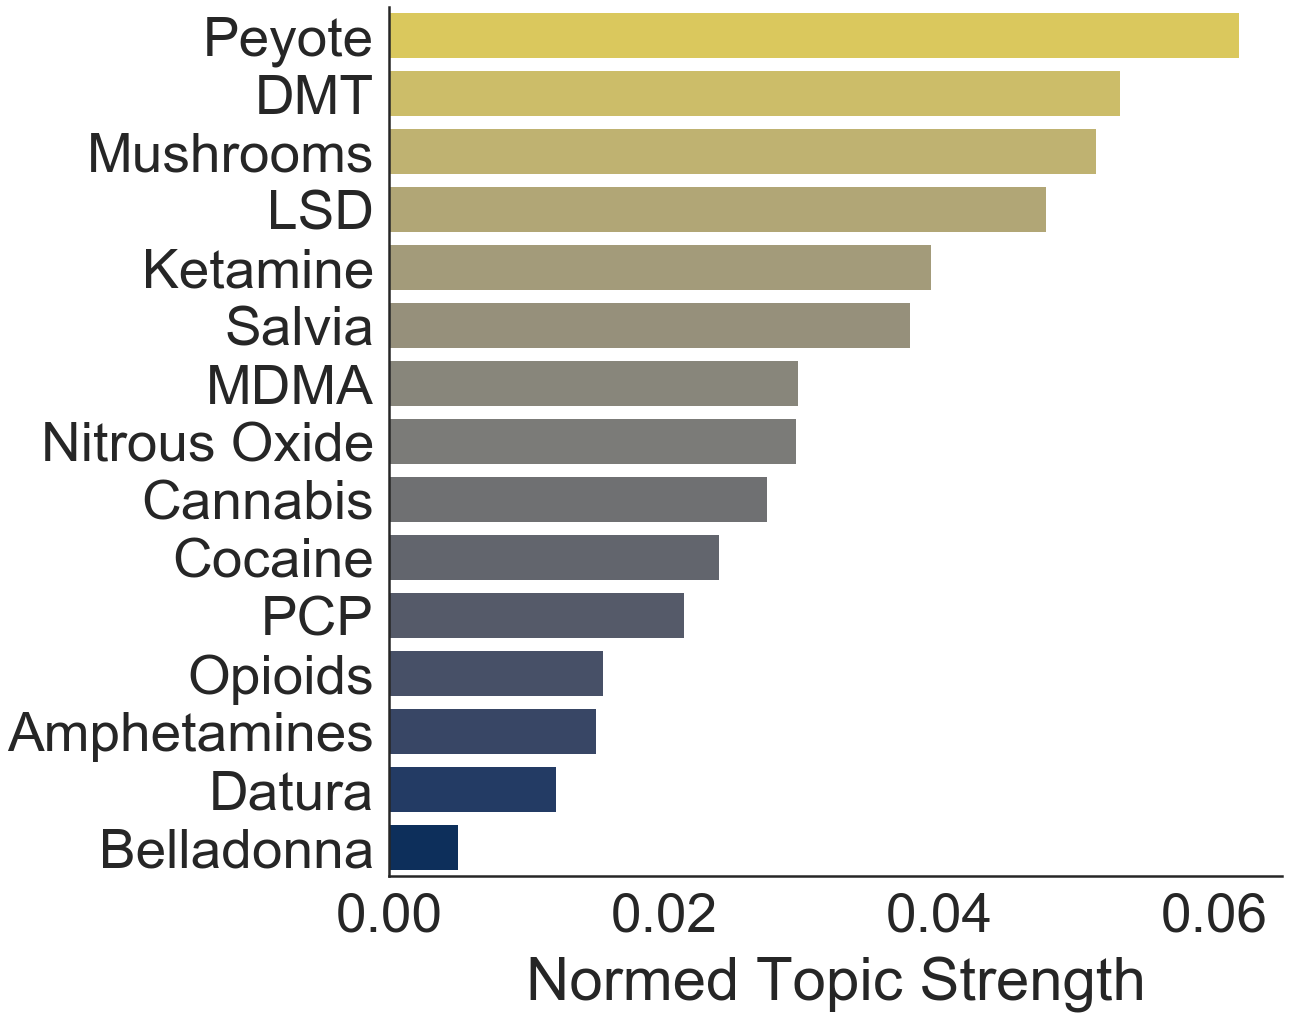

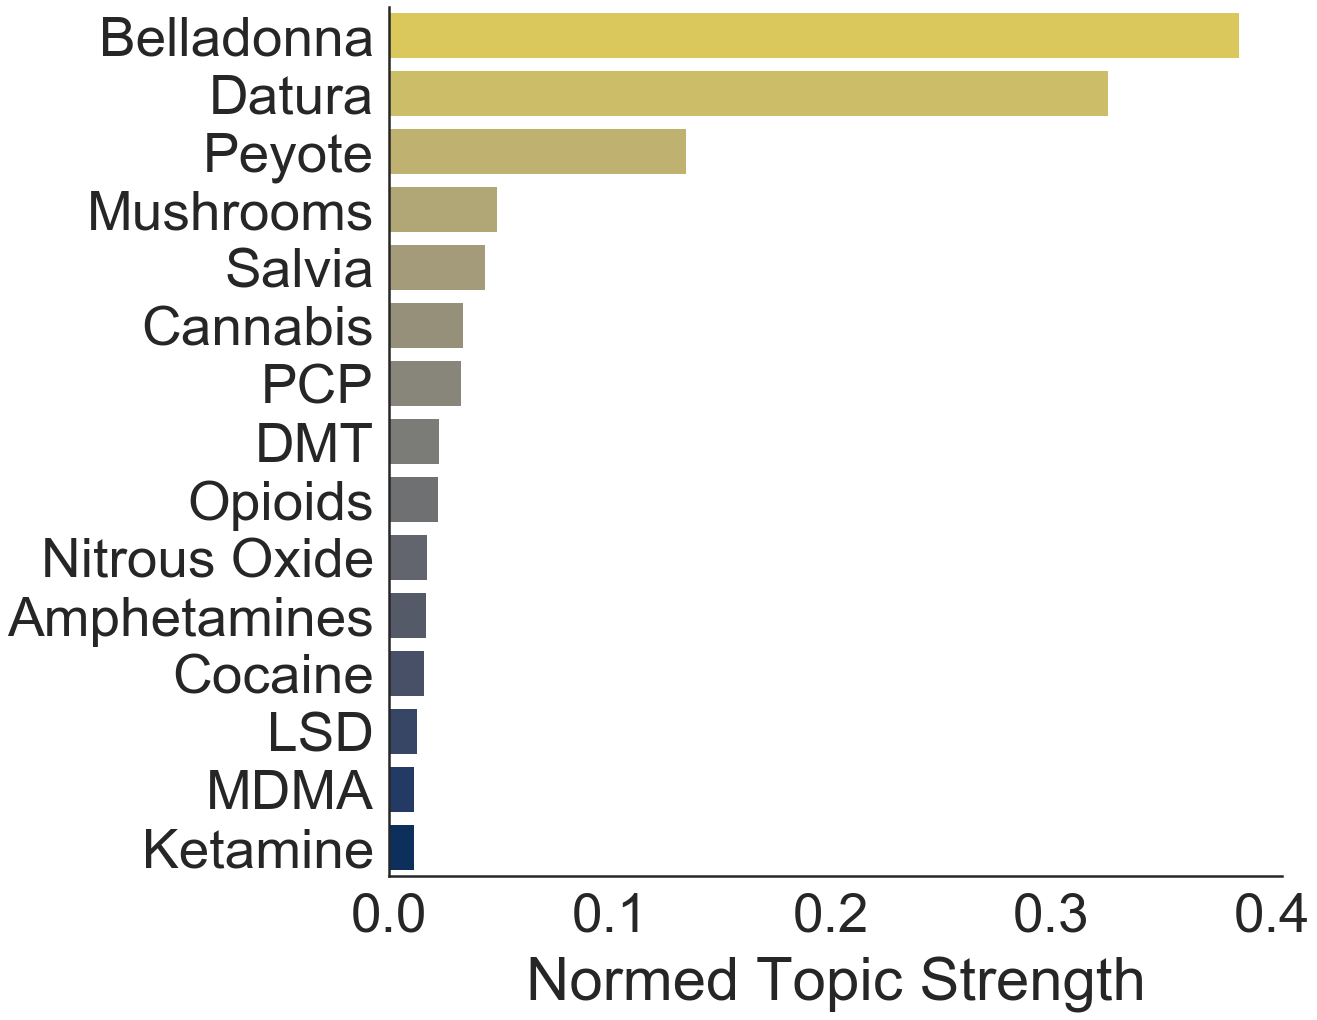

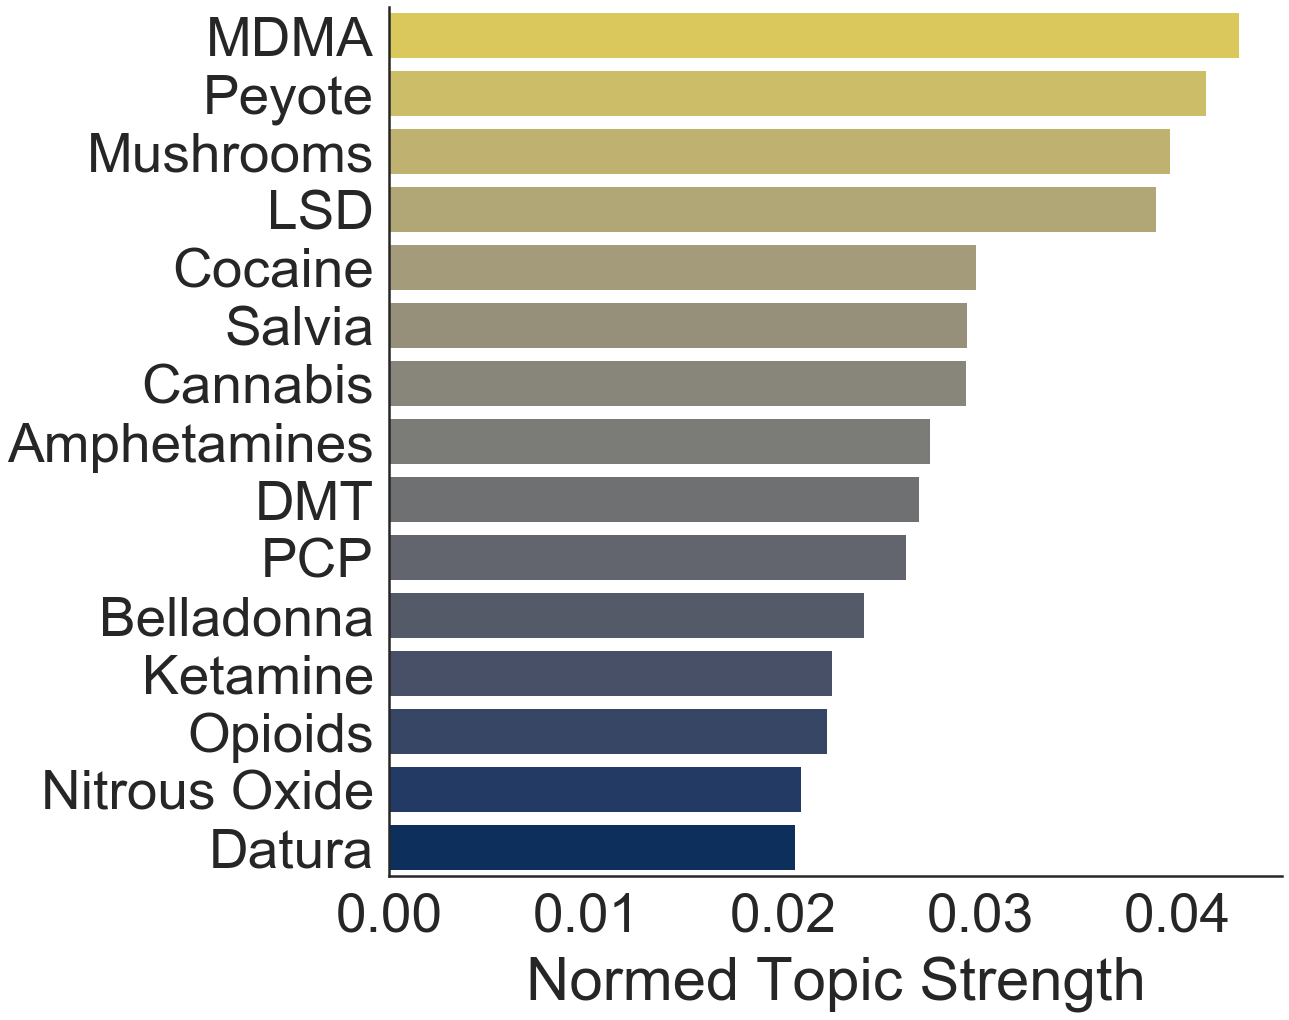

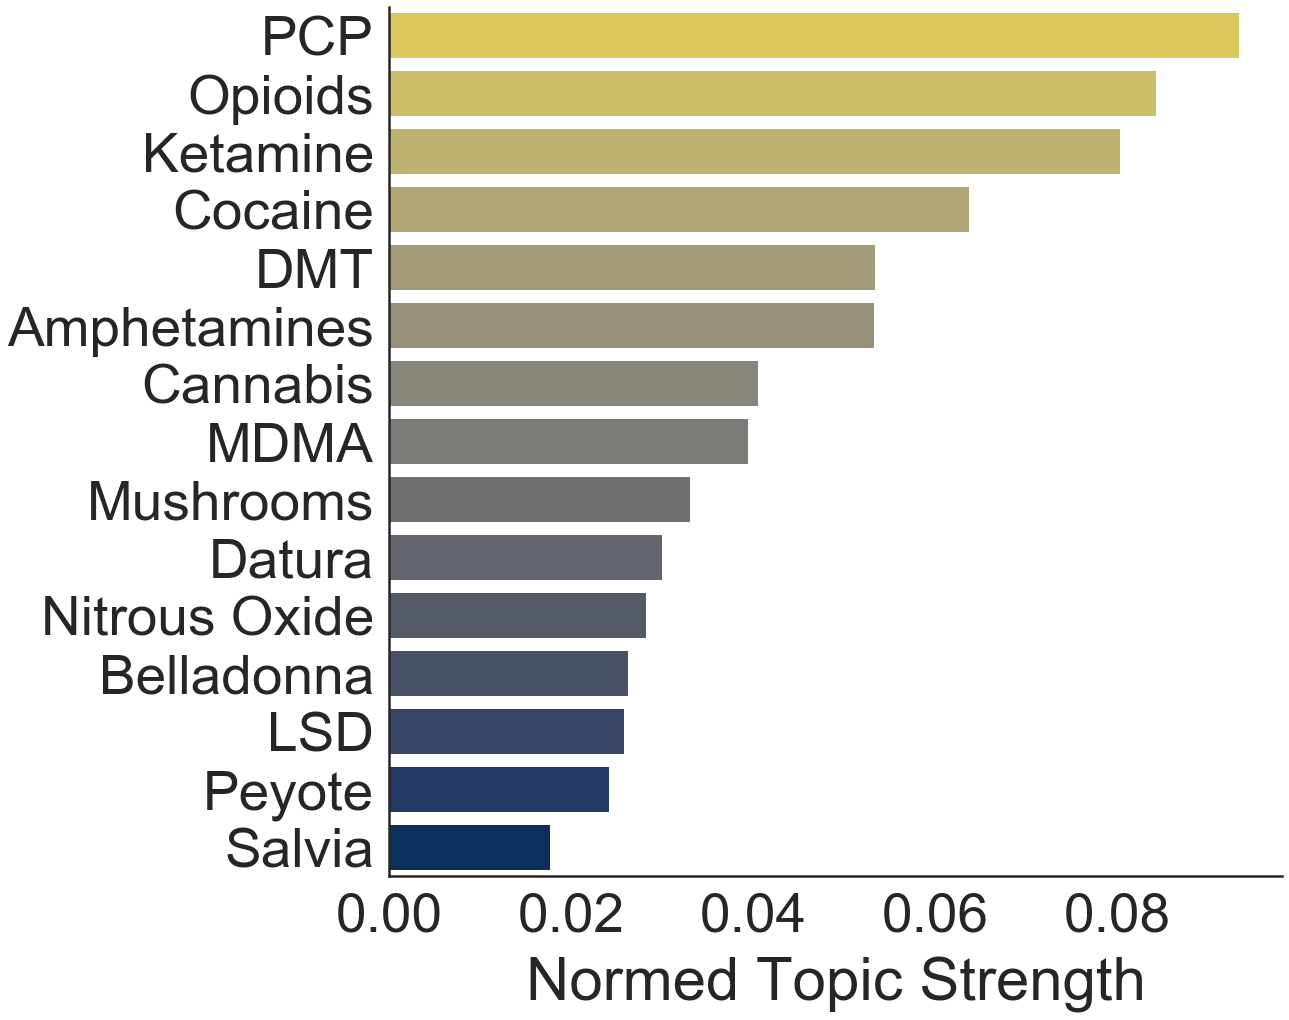

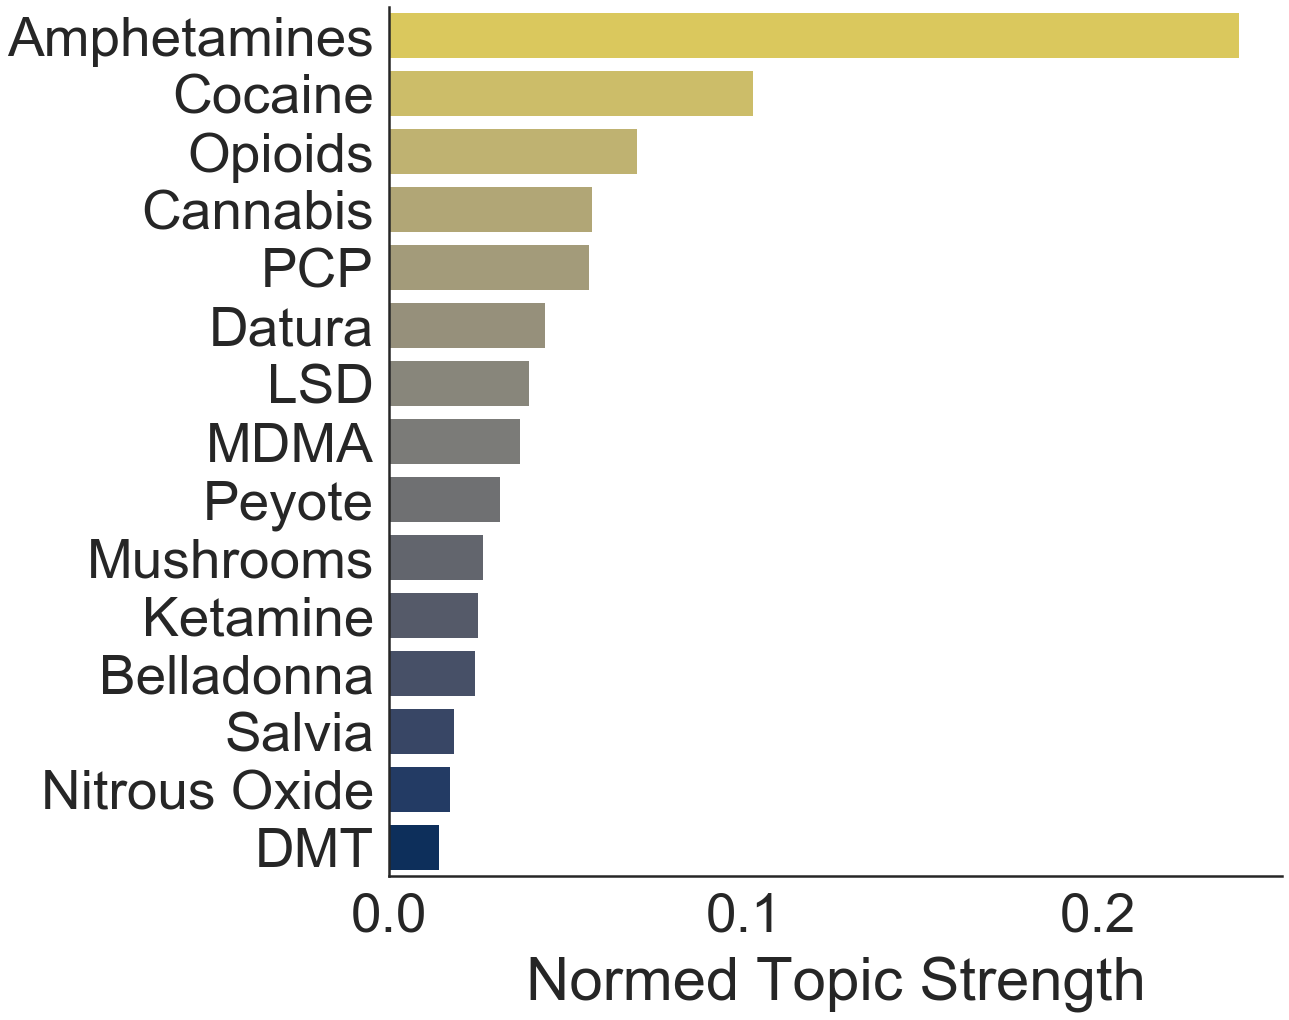

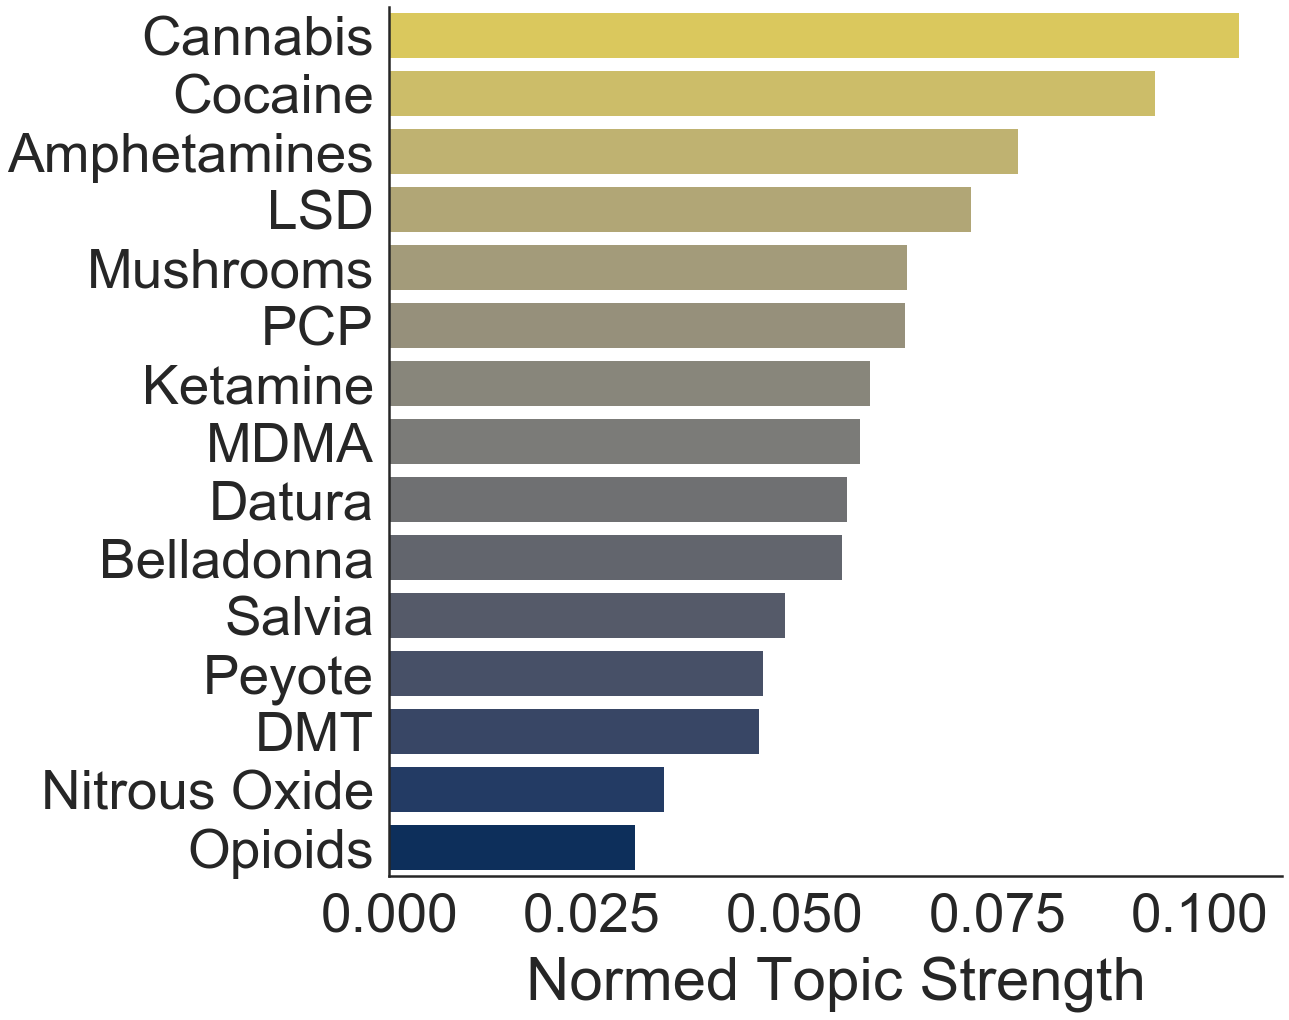

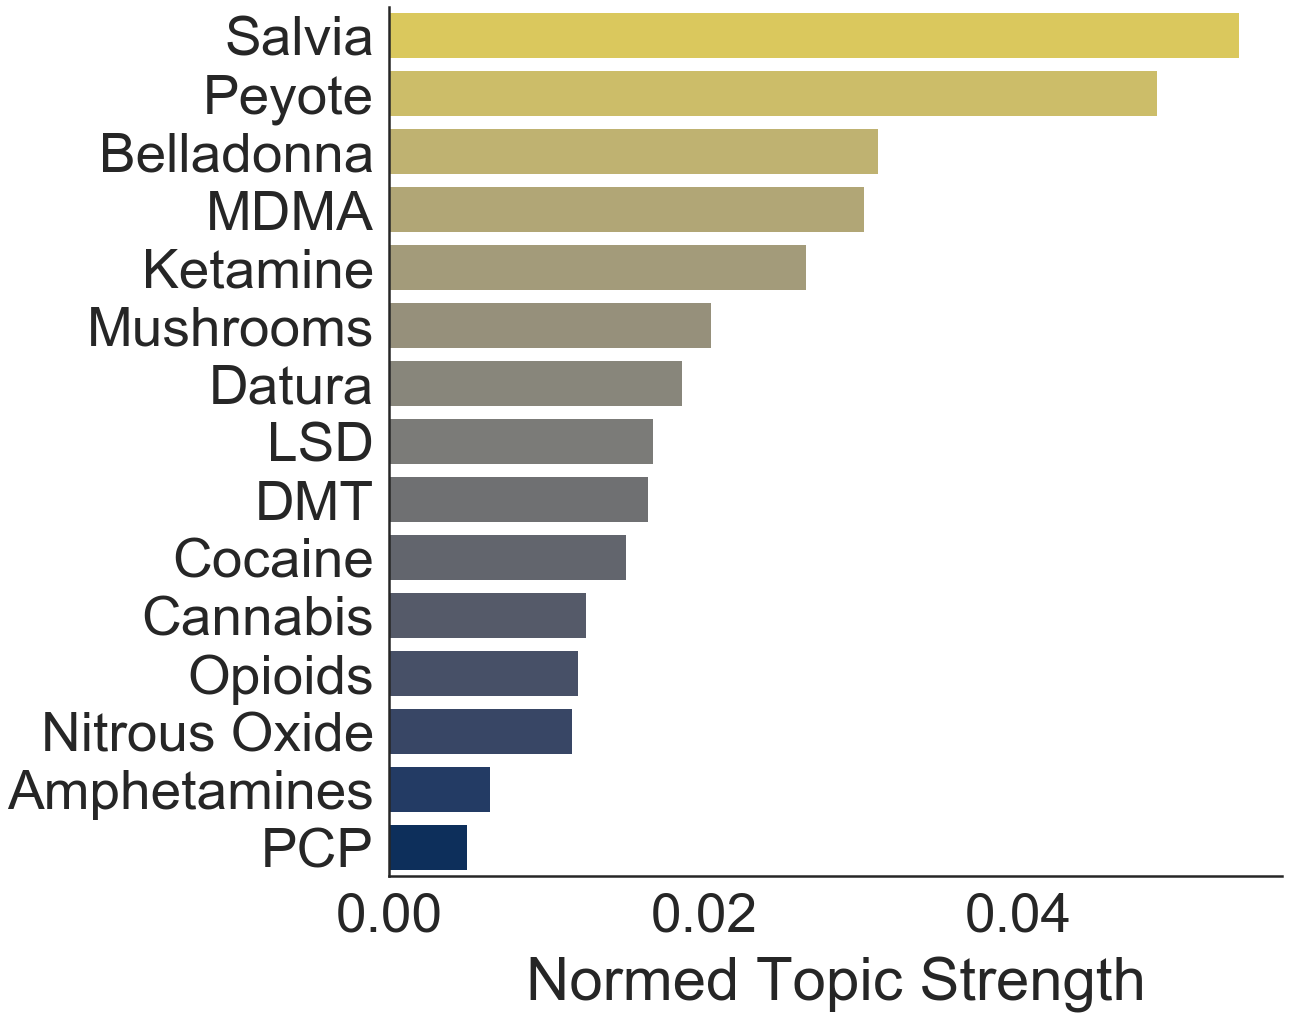

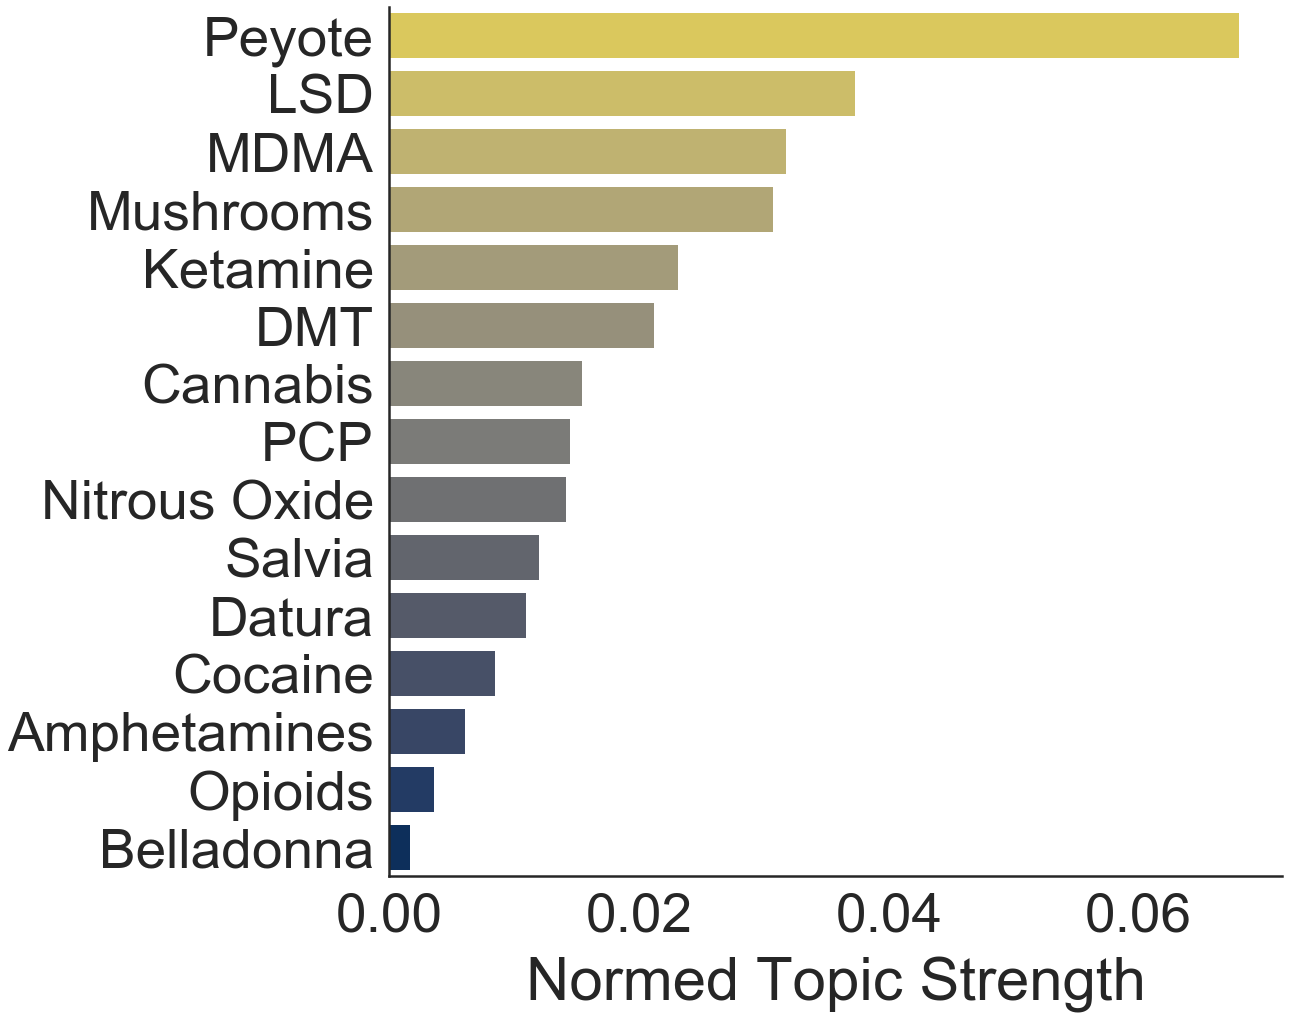

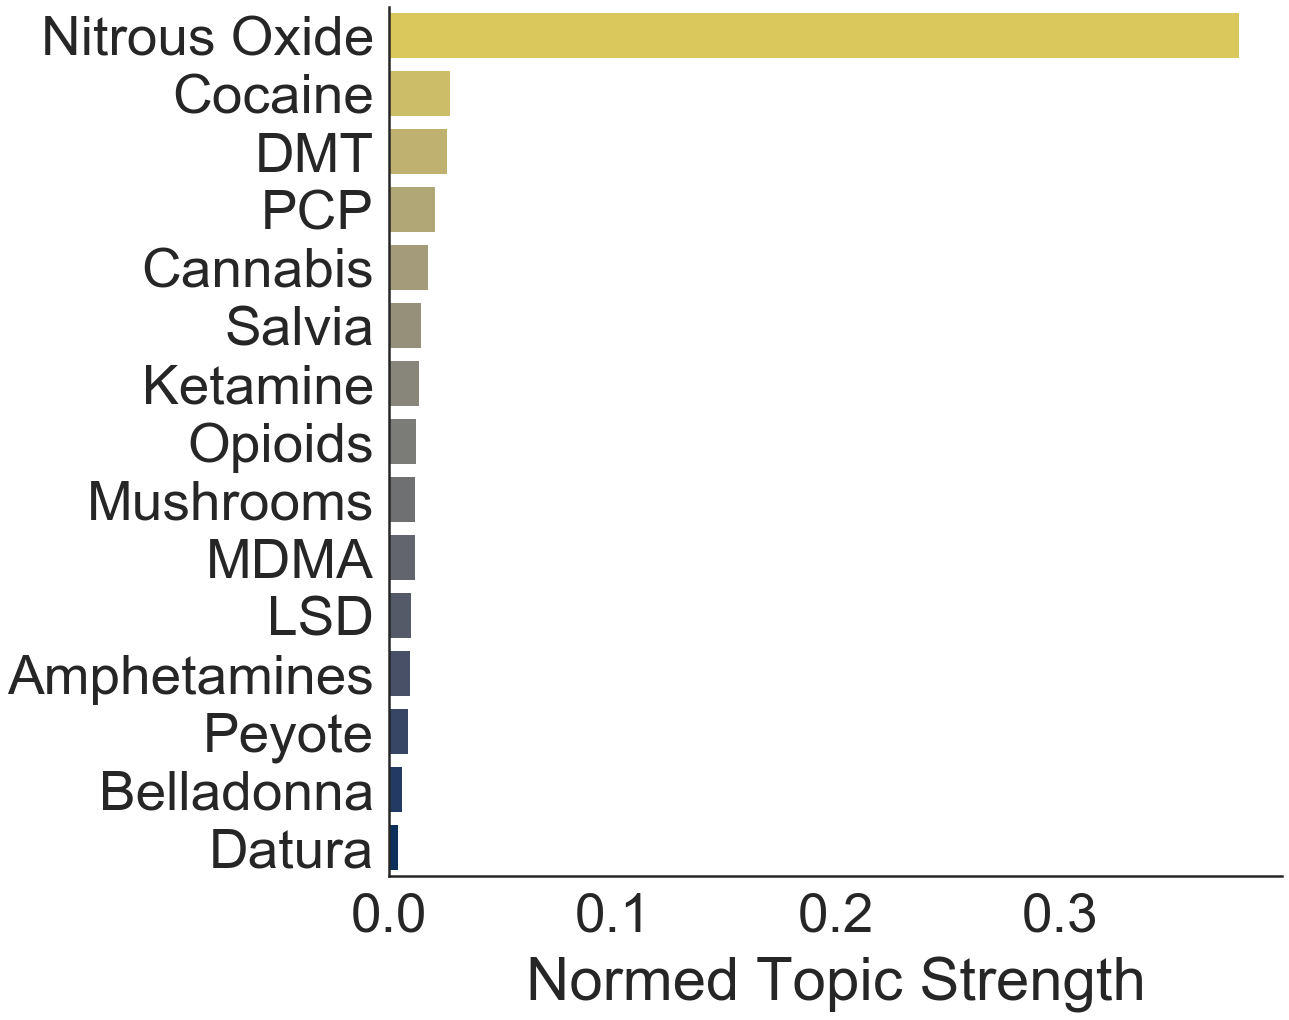

In [201]:
plot_topic_dists(drug_topic_agg)

## Plot topics vs gender

In [59]:
n_topics = 21
col_list = ['topic_' + str(i) for i in range(n_topics)]

gender_topic = pd.DataFrame(doc_topic_full.round(5),
                          index = df['gender'],
                          columns=col_list)


gender_topic.head()

topic_0  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  \
gender                                                                  
M       0.00000  0.06774  0.04733  0.01872  0.00000  0.00000  0.00000   
M       0.00652  0.03434  0.01004  0.00000  0.00691  0.00000  0.00000   
M       0.00975  0.07038  0.00000  0.02709  0.01495  0.00000  0.00000   
M       0.02961  0.04600  0.00000  0.04137  0.02381  0.00000  0.00136   
F       0.05699  0.02832  0.00389  0.02004  0.00244  0.03153  0.00271   

        topic_7  topic_8  topic_9  topic_10  topic_11  topic_12  topic_13  \
gender                                                                      
M       0.02659  0.00000  0.00000  0.00027   0.02471   0.01953   0.00761    
M       0.07316  0.00000  0.00335  0.00000   0.00098   0.01027   0.00257    
M       0.04259  0.00111  0.00000  0.00083   0.00000   0.00814   0.00836    
M       0.01710  0.00000  0.00890  0.01415   0.00000   0.00699   0.00000    
F       0.00558  0.00046  0.00000  0.00000   0.01407   0.00478   0.00000    

        topic_14  topic_15  topic_16  topic_17  topic_18  topic_19  topic_20  
gender                                                                        
M       0.00105   0.00165   0.00394   0.03911   0.00014   0.03274   0.00124   
M       0.00000   0.00752   0.00189   0.00000   0.00264   0.02944   0.00022   
M       0.00125   0.00762   0.00199   0.00000   0.00000   0.00041   0.00811   
M       0.00000   0.00000   0.02221   0.01116   0.00000   0.00000   0.00000   
F       0.00190   0.00000   0.01520   0.00633   0.00000   0.00278   0.00000

In [139]:
gender_topic_agg = gender_topic.groupby('gender').mean()
gender_topic_agg.columns = topic_names
gender_topic_agg.head()

House  Profound  Euphoria_Body   Visuals     Party  Beginning  \
gender                                                                     
F       0.011669  0.014522  0.014451       0.009797  0.014734  0.006791    
M       0.010370  0.019369  0.015889       0.011753  0.008247  0.007010    

        Boyfriend    Nature   Driving  Salvia_DMT   Opioids  Weirdness  \
gender                                                                   
F       0.018648   0.007784  0.007427  0.00690     0.006587  0.011860    
M       0.000897   0.008969  0.006661  0.01136     0.005456  0.012672    

        Spiritual  Ingestion  Girlfriend  Erowid Note    School     Panic  \
gender                                                                      
F       0.006775   0.004600   0.002842    0.004697     0.007309  0.016257   
M       0.006773   0.006578   0.006677    0.007426     0.007508  0.010420   

          Family  Festival  Nitrous Oxide  
gender                                     
F       0.002428  0.005091  0.005066       
M       0.004686  0.004008  0.004287

In [141]:
def plot_topics_gender(gender_topic_agg, drop_cols=None):
    """
    Make grouped barplot of topic representations
    over genders
    
    agg_df: gender as index, topics as columns, aggregated topic
            strenghts in each cell
    
    drop_cols: list of topics to exclude from the plot
    """
    
    if drop_cols:
        gender_topic_agg_sub = gender_topic_agg.drop(labels=drop_cols, axis=1)
    else:
        gender_topic_agg_sub = gender_topic_agg
    
    # Normalize each row by row sum first
    gender_topic_agg_normed = gender_topic_agg_sub.div(gender_topic_agg.sum(axis=1), axis=0)
    
    # Put agg df into long format
    long_df = pd.melt(gender_topic_agg_normed.reset_index(), id_vars=['gender'])
    long_df.columns = ['Gender', 'Topic', 'Normed Strength']
    
    # Make plot
    fig, ax = plt.subplots(figsize=(12, 16))
    sns.barplot(x='Normed Strength', y='Topic', hue='Gender', data=long_df)
    sns.despine()
    ax.set_ylabel('')
    ax.set_xlabel('Normed Topic Strengths')

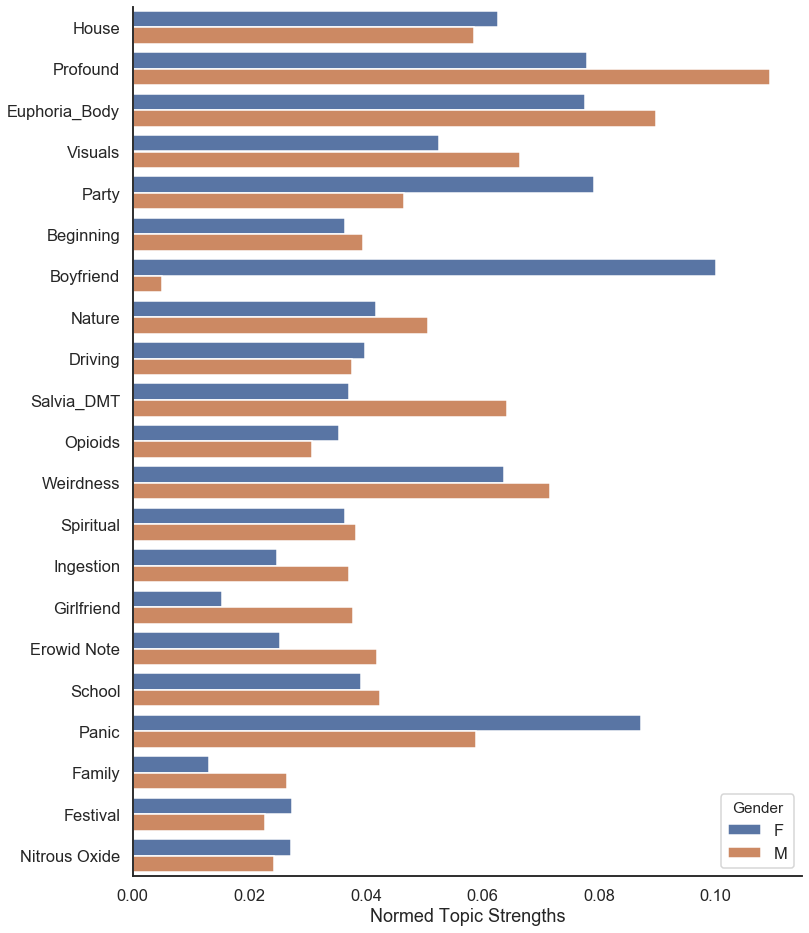

In [145]:
plot_topics_gender(gender_topic_agg)

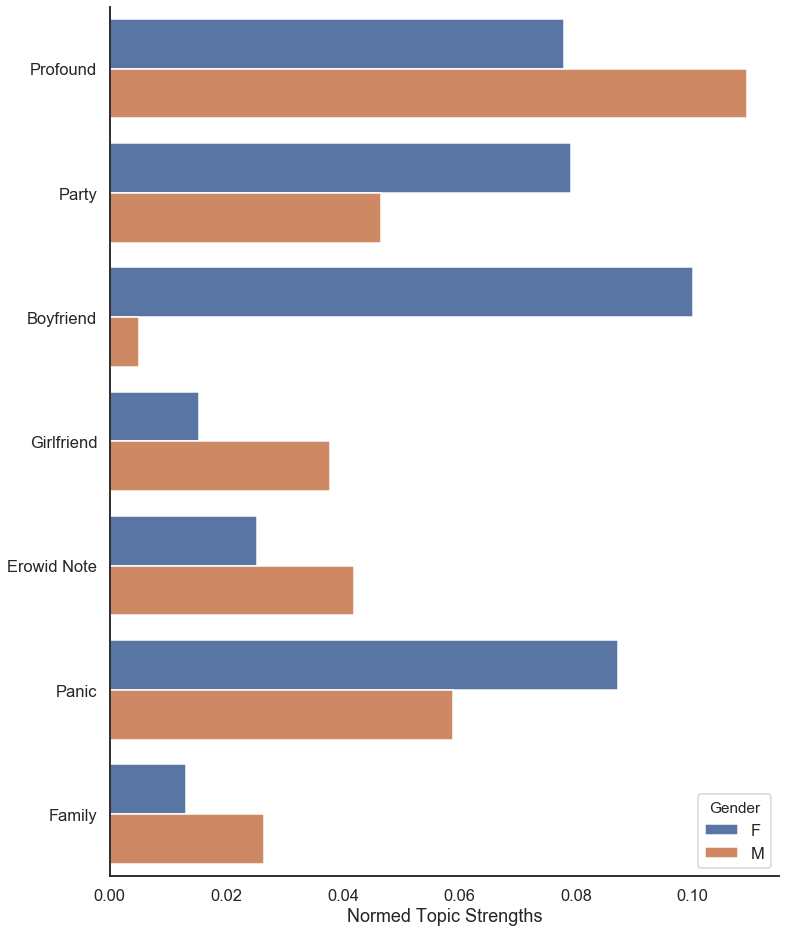

In [144]:
drop_cols_gender_plot = ['House', 'Beginning', 'Driving', 'Salvia_DMT', 'Opioids', 'Weirdness', 'Spiritual',
                         'Ingestion', 'School', 'Festival', 'Nitrous Oxide', 'Euphoria_Body', 'Visuals', 'Nature']
plot_topics_gender(gender_topic_agg, drop_cols=drop_cols_gender_plot)